
Step 1 — NLP Preprocessing & Exploratory Analysis (20 Newsgroups subset)
------------------------------------------------------------------------
What this script includes:
1) Dataset loading (20 Newsgroups subset; with offline fallback)
2) Robust preprocessing pipeline with safe fallbacks (POS lemma optional)
3) Validation of preprocessing quality (before/after stats + spot-checks)
4) Exploratory analysis: frequencies, length distributions, PMI bigrams, per-class terms
5) Ablation: raw vs. cleaned vs. stemming (macro-F1 comparison)
6) Feature interpretation: top TF-IDF features per class (robust to coef_ type)
7) Baseline model (TF-IDF + LinearSVC) and optional model save

Deps:  numpy, pandas, scikit-learn, nltk, matplotlib, joblib

In [1]:
# =========================
# Imports & Config
# =========================
import re, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from typing import List

RANDOM_STATE = 42
USE_POS_LEMMA = True           # set False if POS tagger download is problematic
APPLY_DOMAIN_STOPWORDS = True  # domain words to drop (greetings/signatures/etc.)

# Domain stopwords (extend as needed for your forum setting)
DOMAIN_STOP = {
    "thanks","thank","hi","hello","please","regards","best",
    "don","t","ve","re","subject","would","could","also",
    "com","org","edu"
}


In [2]:
import sys
!{sys.executable} -m pip install nltk

In [3]:
# =========================
# NLTK (downloads with safety)
# =========================
import nltk
def ensure_nltk_data():
    pkgs = [
        ("tokenizers/punkt", "punkt"),
        ("corpora/stopwords", "stopwords"),
        ("corpora/wordnet", "wordnet"),
    ]
    # POS tagger (both names to cover NLTK 3.8/3.9+)
    if USE_POS_LEMMA:
        pkgs += [
            ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
            ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
        ]
    for path, pkg in pkgs:
        try:
            nltk.data.find(path)
        except LookupError:
            nltk.download(pkg, quiet=True)

ensure_nltk_data()

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
from nltk.util import ngrams


In [4]:
# =========================
# Sklearn toolset
# =========================
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
import joblib

In [5]:
# =========================
# Helpers: normalization & preprocessing
# =========================
def wn_pos_from_tag(tag: str):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

EN_STOP = set(stopwords.words("english"))

def normalize_text(text: str) -> str:
    """Lowercase, keep negations, remove URLs/emails/code/nums/punct; letters only."""
    if not isinstance(text, str): return ""
    t = text.lower()
    t = re.sub(r"n['’]t\b", " not", t)                     # keep negation signal
    t = re.sub(r"http\S+|www\.\S+|\S+@\S+\.\S+", " ", t)   # URLs & emails
    t = re.sub(r"`{1,3}.*?`{1,3}", " ", t)                 # inline code fences
    t = re.sub(r"\d+", " ", t)                             # numbers
    t = re.sub(r"[^a-z\s]", " ", t)                        # letters only
    t = re.sub(r"\s+", " ", t).strip()
    return t

def preprocess_tokens(text: str,
                      remove_stop: bool = True,
                      lemma: bool = True,
                      min_len: int = 2,
                      add_domain_stop: bool = APPLY_DOMAIN_STOPWORDS) -> List[str]:
    """Tokenize, stopword filtering, optional POS-aware lemmatization."""
    t = normalize_text(text)
    toks = word_tokenize(t)
    if remove_stop:
        sw = EN_STOP | (DOMAIN_STOP if add_domain_stop else set())
        toks = [w for w in toks if w not in sw]
    toks = [w for w in toks if len(w) >= min_len]
    if lemma and toks:
        lemm = WordNetLemmatizer()
        if USE_POS_LEMMA:
            try:
                tagged = pos_tag(toks, lang="eng")
                toks = [lemm.lemmatize(w, wn_pos_from_tag(p)) for w, p in tagged]
            except LookupError:
                toks = [lemm.lemmatize(w, wordnet.NOUN) for w in toks]
        else:
            toks = [lemm.lemmatize(w, wordnet.NOUN) for w in toks]
    return toks

def plot_confusion_matrix(cm: np.ndarray, labels: list, title: str):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i,j], ha="center", va="center", fontsize=9)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    fig.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

In [6]:
# =========================
# 1) Load dataset (with offline fallback)
# =========================
print("=== Loading dataset ===")
categories = ["comp.graphics", "rec.autos", "sci.space", "talk.politics.misc"]
try:
    ng = fetch_20newsgroups(subset="train", categories=categories, random_state=RANDOM_STATE)
    df = pd.DataFrame({
        "text": ng.data,
        "category": [ng.target_names[t] for t in ng.target]
    })
except Exception as e:
    print("Warning: fetch_20newsgroups failed. Using fallback mini dataset.")
    df = pd.DataFrame({
        "text": [
            "OpenGL pipeline optimization and GPU shaders improve rendering.",
            "My car engine makes strange noise after a long drive.",
            "The space mission to Mars requires orbital mechanics.",
            "Debate about new tax policies and political reforms.",
            "3D graphics with ray tracing and lighting models.",
            "Changing tires and choosing motor oil for cars.",
            "Astronauts train for the international space station.",
            "Miscellaneous political news and policy discussion."
        ],
        "category": [
            "comp.graphics","rec.autos","sci.space","talk.politics.misc",
            "comp.graphics","rec.autos","sci.space","talk.politics.misc"
        ]
    })

print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:\n", df["category"].value_counts())
print("\nSample rows:\n", df.head(3))

=== Loading dataset ===
Dataset shape: (2236, 2)

Category distribution:
 category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample rows:
                                                 text            category
0  From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...       comp.graphics
1  From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...  talk.politics.misc
2  From: rick@trystro.uucp (Richard Nickle)\nSubj...           sci.space



=== Preprocessing ===

[Validation]
Documents: 2236
Avg words (raw): 291.9
Avg tokens (clean): 153.1
Vocab size (clean): 23514

--- Doc 0 (comp.graphics) ---
RAW: From: nfotis@ntua.gr (Nick C. Fotis) Subject: Re: more on radiosity Organization: National Technical University of Athens Lines: 34  amann@iam.unibe.ch (Stephan Amann) writes:  >In article 66319@yuma.
TOK: ['nick', 'fotis', 'radiosity', 'organization', 'national', 'technical', 'university', 'athens', 'line', 'stephan', 'amann', 'write', 'article', 'xia', 'zhao', 'write', 'article', 'write', 'let', 'serious', 'work', 'radiosity', 'package', 'write', 'like', 'make', 'public', 'domain', 'announce', 'minute']

--- Doc 1 (talk.politics.misc) ---
RAW: From: cdm@pmafire.inel.gov (Dale Cook) Subject: Re: Good Neighbor Political Hypocrisy Test Organization: WINCO Lines: 25  In article <1993Apr15.193603.14228@magnus.acs.ohio-state.edu> rscharfy@magnus.
TOK: ['dale', 'cook', 'good', 'neighbor', 'political', 'hypocrisy', 'test', 'organi

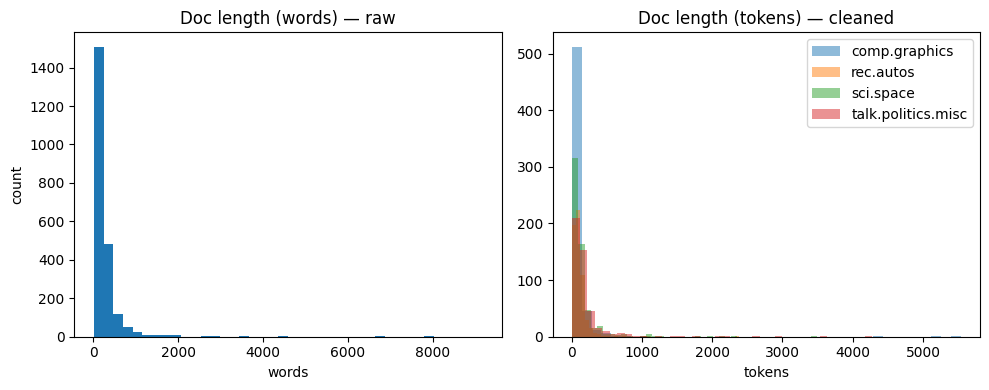

In [7]:
# =========================
# 2) Preprocessing & Validation
# =========================
print("\n=== Preprocessing ===")
df["len_chars_raw"] = df["text"].astype(str).str.len()
df["len_words_raw"] = df["text"].astype(str).str.split().map(lambda x: len(x) if isinstance(x, list) else 0)

df["processed_tokens"] = df["text"].apply(preprocess_tokens)
df["len_tokens_clean"] = df["processed_tokens"].map(len)

# Validation summary
vocab_after = set(w for doc in df["processed_tokens"] for w in doc)
print("\n[Validation]")
print("Documents:", len(df))
print("Avg words (raw):", round(df["len_words_raw"].mean(), 2))
print("Avg tokens (clean):", round(df["len_tokens_clean"].mean(), 2))
print("Vocab size (clean):", len(vocab_after))

# Spot-check a few docs (before/after)
for i in range(min(3, len(df))):
    print(f"\n--- Doc {i} ({df.loc[i,'category']}) ---")
    print("RAW:", df.loc[i, "text"][:200].replace("\n"," "))
    print("TOK:", df.loc[i, "processed_tokens"][:30])

# Length distributions (overall + per class)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(df["len_words_raw"], bins=40)
ax[0].set_title("Doc length (words) — raw"); ax[0].set_xlabel("words"); ax[0].set_ylabel("count")
for cat, g in df.groupby("category"):
    ax[1].hist(g["len_tokens_clean"], bins=40, alpha=0.5, label=cat)
ax[1].set_title("Doc length (tokens) — cleaned"); ax[1].set_xlabel("tokens"); ax[1].legend()
plt.tight_layout(); plt.show()

In [8]:
# =========================
# 3) Exploratory & Descriptive Analysis
# =========================
print("\n=== Exploratory Analysis ===")
# Overall unigrams/bigrams
all_toks = [t for doc in df["processed_tokens"] for t in doc]
print("\nTop 20 unigrams:", Counter(all_toks).most_common(20))
print("\nTop 20 bigrams:", [(" ".join(bg), c) for bg, c in Counter(ngrams(all_toks, 2)).most_common(20)])

# Per-class top tokens (raw frequency)
print("\nTop tokens per class (freq):")
for cat, g in df.groupby("category"):
    toks = [t for doc in g["processed_tokens"] for t in doc]
    print(f"\n[{cat}]")
    for w, c in Counter(toks).most_common(12):
        print(f"{w:<18} {c}")

# PMI bigrams (overall + per class)
def top_bigrams_pmi(token_lists, topk=12, min_df=3):
    corpus = [" ".join(toks) for toks in token_lists]
    # bigram counts
    cv_bg = CountVectorizer(tokenizer=str.split, preprocessor=None, ngram_range=(2,2), min_df=min_df)
    Xbg = cv_bg.fit_transform(corpus)
    bigrams = np.array(cv_bg.get_feature_names_out())
    c_xy = np.asarray(Xbg.sum(axis=0)).ravel()
    # unigram counts
    cv_uni = CountVectorizer(tokenizer=str.split, preprocessor=None, ngram_range=(1,1), min_df=min_df)
    Xu = cv_uni.fit_transform(corpus)
    vocab_u = np.array(cv_uni.get_feature_names_out())
    c_x = np.asarray(Xu.sum(axis=0)).ravel()
    N = int(c_x.sum())
    idx_u = {w:i for i,w in enumerate(vocab_u)}
    scores = []
    for i, bg in enumerate(bigrams):
        w1, w2 = bg.split()
        if w1 in idx_u and w2 in idx_u:
            pxy = c_xy[i] / N
            px  = c_x[idx_u[w1]] / N
            py  = c_x[idx_u[w2]] / N
            if pxy>0 and px>0 and py>0:
                scores.append((bg, float(np.log(pxy/(px*py)))))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:topk]

print("\n[PMI] Top bigrams overall:")
for bg, s in top_bigrams_pmi(df["processed_tokens"], topk=12):
    print(f"{bg:<28} {s: .3f}")

print("\n[PMI] Top bigrams per class:")
for cat, g in df.groupby("category"):
    tops = top_bigrams_pmi(g["processed_tokens"], topk=10)
    print(f"\n[{cat}]")
    for bg, s in tops:
        print(f"{bg:<28} {s: .3f}")



=== Exploratory Analysis ===

Top 20 unigrams: [('line', 2654), ('organization', 2315), ('article', 1843), ('get', 1716), ('write', 1705), ('one', 1591), ('post', 1586), ('use', 1547), ('space', 1504), ('go', 1371), ('car', 1289), ('make', 1280), ('think', 1273), ('say', 1249), ('like', 1241), ('know', 1235), ('university', 1160), ('people', 1124), ('time', 1121), ('host', 1055)]

Top 20 bigrams: [('nntp post', 1027), ('post host', 1024), ('line article', 607), ('line nntp', 387), ('organization university', 374), ('mr stephanopoulos', 341), ('write article', 262), ('distribution world', 209), ('line distribution', 204), ('usa line', 198), ('writes article', 165), ('distribution usa', 146), ('reply organization', 134), ('article write', 119), ('world nntp', 118), ('university line', 118), ('clayton cramer', 114), ('anyone know', 113), ('state university', 110), ('new york', 107)]

Top tokens per class (freq):

[comp.graphics]
image              830
line               806
graphic      

/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


alexei leonov                 11.575
amp ohm                       11.575
aron bonar                    11.575
asst scoutmaster              11.575
autres hommes                 11.575
balki bartokomas              11.575
bcstec voodoo                 11.575
blatent contridiction         11.575
chrystal meth                 11.575
cpuserver acsc                11.575
danebury hursley              11.575
decvax hplabs                 11.575

[PMI] Top bigrams per class:

[comp.graphics]
aron bonar                    9.942
balki bartokomas              9.942
birth mankind                 9.942
cpuserver acsc                9.942
danebury hursley              9.942
fork lift                     9.942
garbo uwasa                   9.942
lacked foresight              9.942
lagerkvist fist               9.942
libertarian atheist           9.942

[rec.autos]
aaron lung                    9.919
amp ohm                       9.919
bcstec voodoo                 9.919
christian huebner           

/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



[talk.politics.misc]
chrystal meth                 10.337
deluxe amenity                10.337
ecst csuchico                 10.337
ecstasy chrystal              10.337
firing squad                  10.337
humour lemming                10.337
inet gw                       10.337
itc uva                       10.337
janis joplin                  10.337
keith michalk                 10.337


In [9]:
# =========================
# 4) Ablation: impact of preprocessing on macro-F1
# =========================
print("\n=== Ablation (macro-F1) ===")
y = df["category"]
# Raw pipeline (use TF-IDF's own tokenization & stopwords)
X_raw = df["text"]
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X_raw, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
vec_raw = dict(lowercase=True, stop_words="english", ngram_range=(1,2), max_df=0.9, min_df=5)
pipe_raw = Pipeline([("tfidf", TfidfVectorizer(**vec_raw)), ("clf", LinearSVC(random_state=RANDOM_STATE))])
pipe_raw.fit(Xr_tr, yr_tr)
pred_raw = pipe_raw.predict(Xr_te)
f1_raw = f1_score(yr_te, pred_raw, average="macro")

# Clean tokens (lemma)
X_clean = df["processed_tokens"].apply(lambda toks: " ".join(toks))
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(X_clean, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
vec_clean = dict(lowercase=False, tokenizer=str.split, preprocessor=None, stop_words=None, ngram_range=(1,2), max_df=0.9, min_df=5)
pipe_clean = Pipeline([("tfidf", TfidfVectorizer(**vec_clean)), ("clf", LinearSVC(random_state=RANDOM_STATE))])
pipe_clean.fit(Xc_tr, yc_tr)
pred_clean = pipe_clean.predict(Xc_te)
f1_clean = f1_score(yc_te, pred_clean, average="macro")

# Stemming (optional)
try:
    stemmer = PorterStemmer()
    df["processed_stem"] = df["processed_tokens"].apply(lambda toks: [stemmer.stem(w) for w in toks])
    X_stem = df["processed_stem"].apply(lambda toks: " ".join(toks))
    Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(X_stem, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    vec_stem = dict(lowercase=False, tokenizer=str.split, preprocessor=None, stop_words=None, ngram_range=(1,2), max_df=0.9, min_df=5)
    pipe_stem = Pipeline([("tfidf", TfidfVectorizer(**vec_stem)), ("clf", LinearSVC(random_state=RANDOM_STATE))])
    pipe_stem.fit(Xs_tr, ys_tr)
    pred_stem = pipe_stem.predict(Xs_te)
    f1_stem = f1_score(ys_te, pred_stem, average="macro")
except Exception:
    pipe_stem, f1_stem = None, None

print(f"Raw text + TF-IDF(stopwords) : {f1_raw:.3f}")
print(f"Clean tokens (lemma)         : {f1_clean:.3f}")
if f1_stem is not None:
    print(f"Clean tokens (stemming)      : {f1_stem:.3f}")

# Choose best pipeline for interpretation
candidates = [(f1_raw, pipe_raw, "Raw"), (f1_clean, pipe_clean, "Lemma")]
if f1_stem is not None:
    candidates.append((f1_stem, pipe_stem, "Stem"))
best_pipe = max(candidates, key=lambda x: x[0])[1]
print("\nSelected pipeline for interpretation.")



=== Ablation (macro-F1) ===


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Raw text + TF-IDF(stopwords) : 0.972
Clean tokens (lemma)         : 0.969
Clean tokens (stemming)      : 0.969

Selected pipeline for interpretation.


In [10]:
# =========================
# 5) Feature interpretation (top features per class)
# =========================
vec = best_pipe.named_steps["tfidf"]
clf = best_pipe.named_steps["clf"]
feature_names = np.array(vec.get_feature_names_out())
class_labels = clf.classes_
coefs = np.array(clf.coef_)   # robust to dense/sparse storage

TOP_K = 15
for i, cls in enumerate(class_labels):
    top = np.argsort(coefs[i])[-TOP_K:][::-1]
    print(f"\nTop features for class: {cls}")
    for r, j in enumerate(top, 1):
        print(f"{r:2d}. {feature_names[j]}")



Top features for class: comp.graphics
 1. graphics
 2. image
 3. 3d
 4. file
 5. animation
 6. video
 7. points
 8. package
 9. polygon
10. color
11. 3do
12. card
13. format
14. files
15. sgi

Top features for class: rec.autos
 1. car
 2. cars
 3. ford
 4. toyota
 5. bmw
 6. engine
 7. auto
 8. chevrolet
 9. honda
10. mazda
11. oil
12. bought
13. automotive
14. dealer
15. warning read

Top features for class: sci.space
 1. space
 2. orbit
 3. moon
 4. launch
 5. nasa
 6. dc
 7. mars
 8. shuttle
 9. rockets
10. lunar
11. astronomy
12. sky
13. planets
14. sci
15. graphics lines

Top features for class: talk.politics.misc
 1. clinton
 2. people
 3. government
 4. tax
 5. drugs
 6. american
 7. gay
 8. sexual
 9. kaldis
10. lynn
11. law
12. state
13. president
14. optilink
15. white



=== Baseline model (TF-IDF + LinearSVC) on raw texts ===

Classification report (LinearSVC):
                     precision    recall  f1-score   support

     comp.graphics      0.934     0.966     0.950       117
         rec.autos      0.975     0.975     0.975       119
         sci.space      0.991     0.958     0.974       119
talk.politics.misc      0.989     0.989     0.989        93

          accuracy                          0.971       448
         macro avg      0.972     0.972     0.972       448
      weighted avg      0.971     0.971     0.971       448



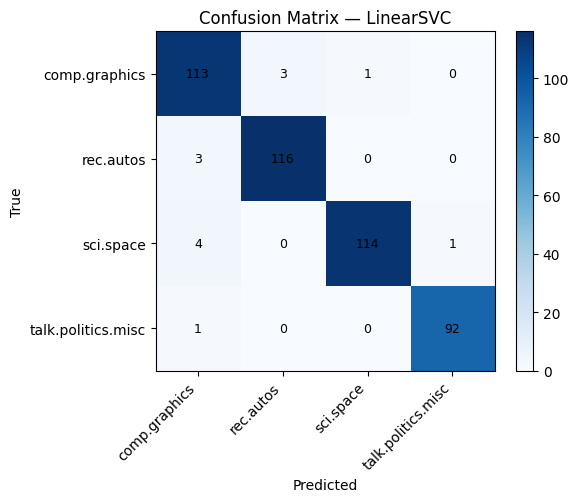


=== Optional: TF-IDF + MultinomialNB ===

Classification report (Naive Bayes):
                     precision    recall  f1-score   support

     comp.graphics      0.919     0.966     0.942       117
         rec.autos      0.951     0.975     0.963       119
         sci.space      0.957     0.941     0.949       119
talk.politics.misc      1.000     0.925     0.961        93

          accuracy                          0.953       448
         macro avg      0.957     0.952     0.954       448
      weighted avg      0.954     0.953     0.953       448



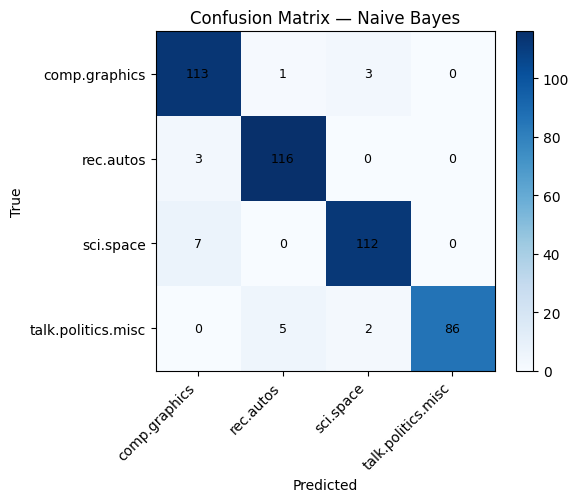

In [11]:
# =========================
# 6) Train a single baseline model on raw texts and evaluate
# =========================
print("\n=== Baseline model (TF-IDF + LinearSVC) on raw texts ===")
X = df["text"]; y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE, stratify=y)
svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2),
                              max_df=0.90, min_df=5)),
    ("svm", LinearSVC(random_state=RANDOM_STATE))
])
svm_pipe.fit(X_train, y_train)
y_pred = svm_pipe.predict(X_test)

print("\nClassification report (LinearSVC):\n", classification_report(y_test, y_pred, digits=3))
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
plot_confusion_matrix(cm, labels, "Confusion Matrix — LinearSVC")

# Optional: compare with Naive Bayes
print("\n=== Optional: TF-IDF + MultinomialNB ===")
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2),
                              max_df=0.90, min_df=5)),
    ("nb", MultinomialNB())
])
nb_pipe.fit(X_train, y_train)
y_pred_nb = nb_pipe.predict(X_test)
print("\nClassification report (Naive Bayes):\n", classification_report(y_test, y_pred_nb, digits=3))
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)
plot_confusion_matrix(cm_nb, labels, "Confusion Matrix — Naive Bayes")


In [12]:
# =========================
# 7) Save the chosen model (example: SVM on raw)
# =========================
MODEL_PATH = "nlp_classifier.pkl"
joblib.dump(svm_pipe, MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")

print("\n=== Done. ===")


Model saved to: nlp_classifier.pkl

=== Done. ===



Part 2 — Time Series Forecasting (S&P 500 example)
--------------------------------------------------
What this script includes:
1) Data loading (yfinance; with offline synthetic fallback)
2) EDA: plotting, rolling stats, log-returns, seasonal decomposition
3) Stationarity checks (ADF on levels and log-returns)
4) Time-aware train/test split
5) Baselines: Naive, Moving Average, Seasonal Naive
6) ARIMA model selection via small AIC grid search
7) Forecast on the ORIGINAL price scale + evaluation (MAE/RMSE/MAPE)


In [13]:
# =========================
# Imports & Config
# =========================
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Statsmodels
from statsmodels.tsa.stattools import adfuller
try:
    from statsmodels.tsa.stattools import kpss
    HAS_KPSS = True
except Exception:
    HAS_KPSS = False

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data source (optional)
try:
    import yfinance as yf
    HAS_YF = True
except Exception:
    HAS_YF = False

# Figure saving
SAVE_FIGS = True
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)
def savefig(name):
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, name), dpi=200, bbox_inches="tight")

RANDOM_STATE = 42

In [14]:
# =========================
# Helpers
# =========================
def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

# Version-agnostic evaluator: no dependency on 'squared' argument
def evaluate(y_true, y_pred, name="model"):
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    # ensure numpy float arrays (Series/Index -> array)
    y_true = np.asarray(y_true, dtype=float)
    try:
        y_pred = np.asarray(y_pred, dtype=float)
    except Exception:
        y_pred = np.asarray(getattr(y_pred, "values", y_pred), dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))  # manual RMSE (works on all sklearn versions)

    eps = 1e-8
    mape_val = float(np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0)

    print(f"{name:24s} MAE={mae:,.3f}  RMSE={rmse:,.3f}  MAPE={mape_val:,.2f}%")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "MAPE": mape_val}

def safe_download_sp500(start="2013-01-01", end="2022-12-31"):
    if not HAS_YF:
        raise RuntimeError("yfinance not available")
    df = yf.download("^GSPC", start=start, end=end, progress=False)
    if df is None or df.empty:
        raise RuntimeError("Empty dataframe from yfinance")
    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    return df[col].rename("price").dropna()

def adf_summary(x, title):
    res = adfuller(x.dropna(), autolag="AIC")
    print(f"{title}: ADF={res[0]:.3f}, p={res[1]:.5f}, lags={res[2]}, nobs={res[3]}")
    return {"ADF": res[0], "p": res[1], "lags": res[2], "nobs": res[3]}

def kpss_summary(x, title):
    if not HAS_KPSS:
        print(f"{title}: KPSS not available (skipping).")
        return None
    stat, p, lags, _ = kpss(x.dropna(), regression="c", nlags="auto")
    print(f"{title}: KPSS={stat:.3f}, p={p:.5f}, lags={lags}")
    return {"KPSS": stat, "p": p, "lags": lags}

def seasonal_strength(stl_res):
    # Hyndman: 1 - var(remainder) / var(seasonal + remainder)
    resid_var = np.var(stl_res.resid.dropna())
    seas_var  = np.var(stl_res.seasonal.dropna())
    denom = seas_var + resid_var
    return 0.0 if denom == 0 else 1 - resid_var / denom


In [15]:
# =========================
# 1) Load data
# =========================
print("=== Loading S&P 500 (2013-01-01 → 2022-12-31) ===")
try:
    ts = safe_download_sp500("2013-01-01", "2022-12-31")
except Exception as e:
    print("Warning: fallback to synthetic data:", e)
    idx = pd.date_range("2013-01-01", "2022-12-31", freq="B")
    vals = np.cumsum(np.random.randn(len(idx))) + 2000
    ts = pd.Series(vals, index=idx, name="price")

print("\nHead:\n", ts.head())
print("\nDescribe:\n", ts.describe())
print(f"\nMissing values: {int(ts.isna().sum())}")

=== Loading S&P 500 (2013-01-01 → 2022-12-31) ===

Head:
 2013-01-01    2001.598538
2013-01-02    2003.836241
2013-01-03    2006.169779
2013-01-04    2005.988828
2013-01-07    2005.755184
Freq: B, Name: price, dtype: float64

Describe:
 count    2609.000000
mean     2009.097892
std        19.433174
min      1962.363416
25%      1993.880291
50%      2017.627293
75%      2023.645232
max      2036.500952
Name: price, dtype: float64

Missing values: 0


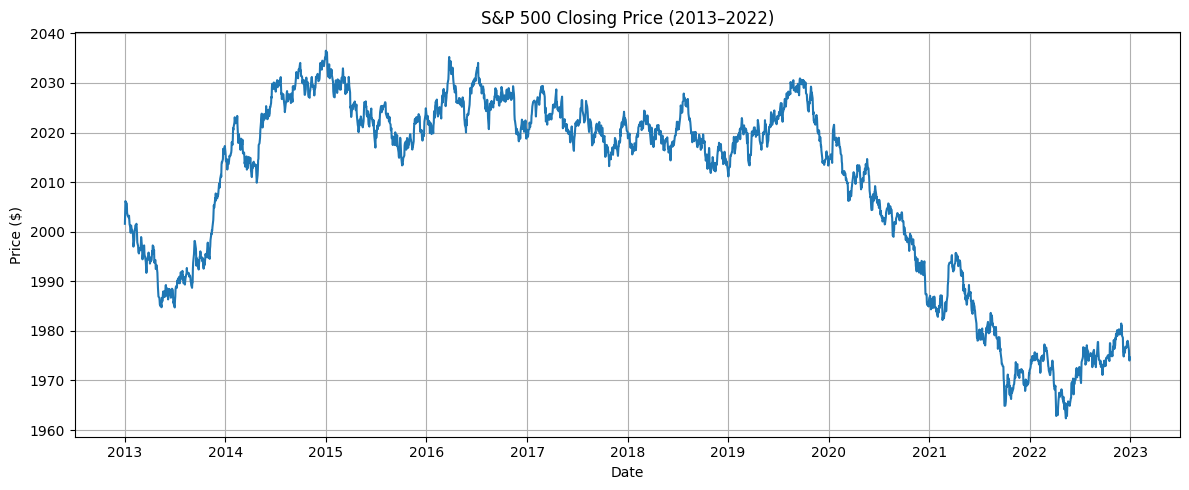

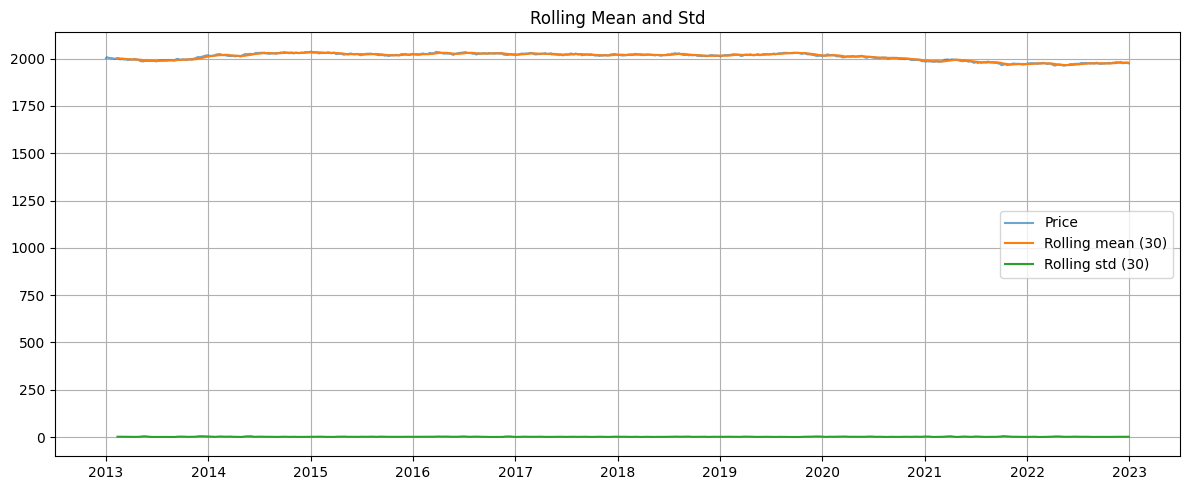

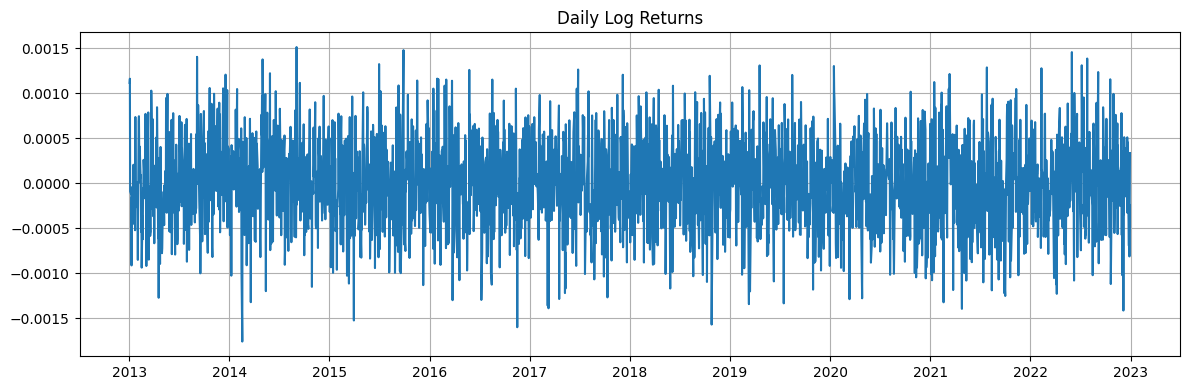

In [16]:
# =========================
# 2) EDA
# =========================
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values)
plt.title("S&P 500 Closing Price (2013–2022)")
plt.xlabel("Date"); plt.ylabel("Price ($)"); plt.grid(True); plt.tight_layout()
savefig("01_price_raw.png"); plt.show()

# Rolling mean/std
roll_w = 30
ts_roll_mean = ts.rolling(roll_w).mean()
ts_roll_std  = ts.rolling(roll_w).std()

plt.figure(figsize=(12,5))
plt.plot(ts, label="Price", alpha=0.65)
plt.plot(ts_roll_mean, label=f"Rolling mean ({roll_w})")
plt.plot(ts_roll_std,  label=f"Rolling std ({roll_w})")
plt.title("Rolling Mean and Std"); plt.legend(); plt.grid(True); plt.tight_layout()
savefig("02_rolling_mean_std.png"); plt.show()

# Log price and returns
log_price = np.log(ts)
log_ret = log_price.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(log_ret); plt.title("Daily Log Returns"); plt.grid(True); plt.tight_layout()
savefig("03_log_returns.png"); plt.show()


=== Stationarity checks ===
Levels (price): ADF=-0.642, p=0.86132, lags=5, nobs=2603
Log(price): ADF=-0.633, p=0.86336, lags=5, nobs=2603
Log returns (diff log): ADF=-24.227, p=0.00000, lags=4, nobs=2603
Levels (price): KPSS=3.812, p=0.01000, lags=30
Log(price): KPSS=3.816, p=0.01000, lags=30
Log returns: KPSS=0.291, p=0.10000, lags=11


/var/folders/n9/jmmjs4z106jczytcwlwjzsx80000gn/T/ipykernel_2085/4118693241.py:49: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, _ = kpss(x.dropna(), regression="c", nlags="auto")
/var/folders/n9/jmmjs4z106jczytcwlwjzsx80000gn/T/ipykernel_2085/4118693241.py:49: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, _ = kpss(x.dropna(), regression="c", nlags="auto")
/var/folders/n9/jmmjs4z106jczytcwlwjzsx80000gn/T/ipykernel_2085/4118693241.py:49: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, _ = kpss(x.dropna(), regression="c", nlags="auto")



Chosen differencing order d = 1 (log scale) based on ADF/KPSS evidence.


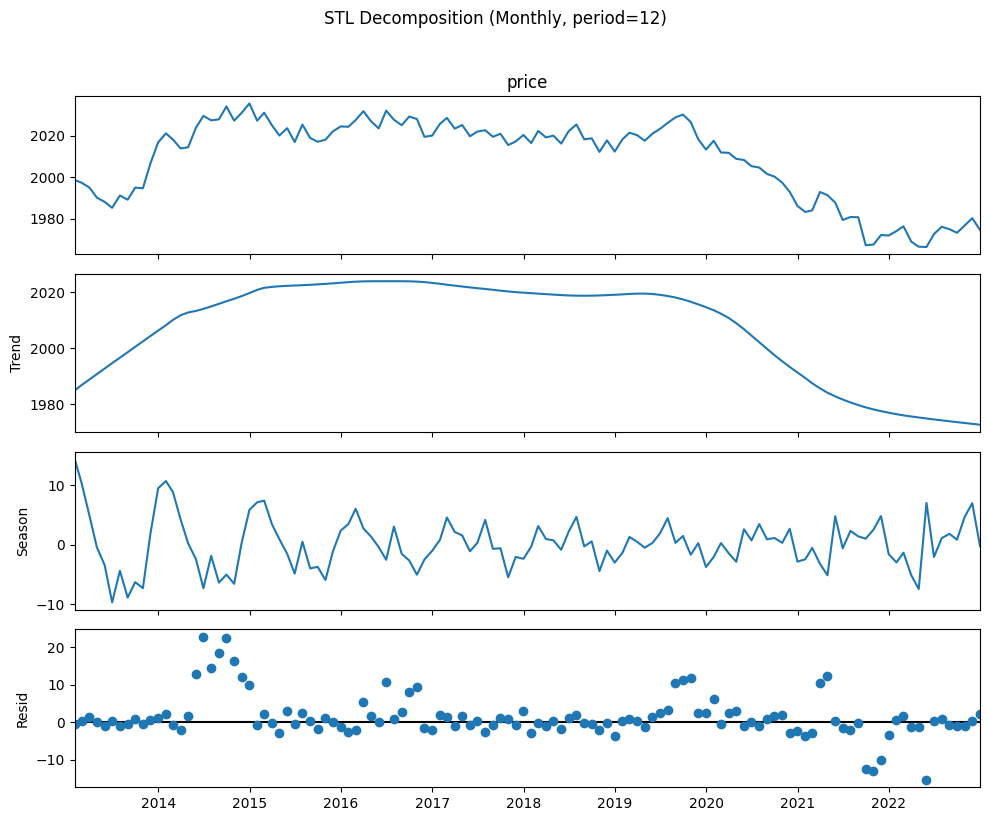

Seasonal strength (STL-based): 0.344  (closer to 1 → stronger seasonality)


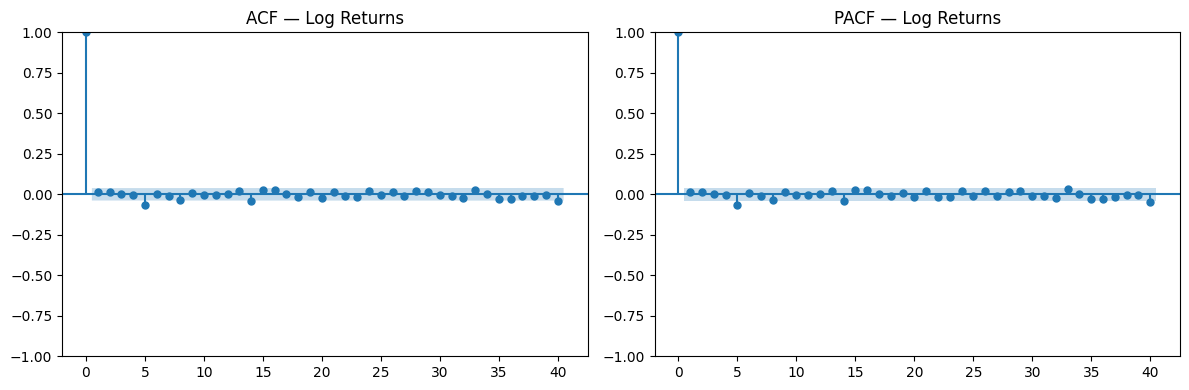

In [17]:
# =========================
# 3) Stationarity & Transformations
# =========================
print("\n=== Stationarity checks ===")
adf_levels = adf_summary(ts, "Levels (price)")
adf_log    = adf_summary(log_price, "Log(price)")
adf_ret    = adf_summary(log_ret, "Log returns (diff log)")

kpss_levels = kpss_summary(ts, "Levels (price)")
kpss_log    = kpss_summary(log_price, "Log(price)")
kpss_ret    = kpss_summary(log_ret, "Log returns")

# Decide differencing order d on log(price)
def is_nonstationary(adf_p, kpss_p):
    adf_ns = (adf_p is not None) and (adf_p > 0.05)
    kpss_ns = (kpss_p is not None) and (kpss_p < 0.05)
    return adf_ns or kpss_ns

adf_p_log  = adfuller(log_price.dropna(), autolag="AIC")[1]
kpss_p_log = None if (kpss_log is None) else kpss_log["p"]
d = 1 if is_nonstationary(adf_p_log, kpss_p_log) else 0
print(f"\nChosen differencing order d = {d} (log scale) based on ADF/KPSS evidence.")

# STL decomposition on monthly data (period=12)
ts_m = ts.resample("M").last()
stl = STL(ts_m, period=12, robust=True).fit()
fig = stl.plot(); fig.set_size_inches(10,8)
fig.suptitle("STL Decomposition (Monthly, period=12)", y=1.02)
plt.tight_layout(); savefig("04_stl_decomposition.png"); plt.show()

strength = seasonal_strength(stl)
print(f"Seasonal strength (STL-based): {strength:.3f}  (closer to 1 → stronger seasonality)")

# ACF/PACF on returns
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(log_ret, lags=40, ax=ax[0]);  ax[0].set_title("ACF — Log Returns")
plot_pacf(log_ret, lags=40, ax=ax[1]); ax[1].set_title("PACF — Log Returns")
plt.tight_layout(); savefig("05_acf_pacf_returns.png"); plt.show()


In [18]:
# =========================
# 4) Time-aware train/test split
# =========================
split_idx = int(len(ts) * 0.8)
train = ts.iloc[:split_idx]
test  = ts.iloc[split_idx:]
print(f"\nTrain: {train.index.min().date()} → {train.index.max().date()}  (n={len(train)})")
print(f"Test : {test.index.min().date()}  → {test.index.max().date()}   (n={len(test)})")


Train: 2013-01-01 → 2020-12-30  (n=2087)
Test : 2020-12-31  → 2022-12-30   (n=522)


In [19]:
!pip install -U scikit-learn


=== Baseline metrics ===
Naive                    MAE=9.583  RMSE=11.001  MAPE=0.49%
MA(20)                   MAE=13.106  RMSE=14.638  MAPE=0.66%
SeasonalNaive(252)       MAE=9.583  RMSE=11.001  MAPE=0.49%


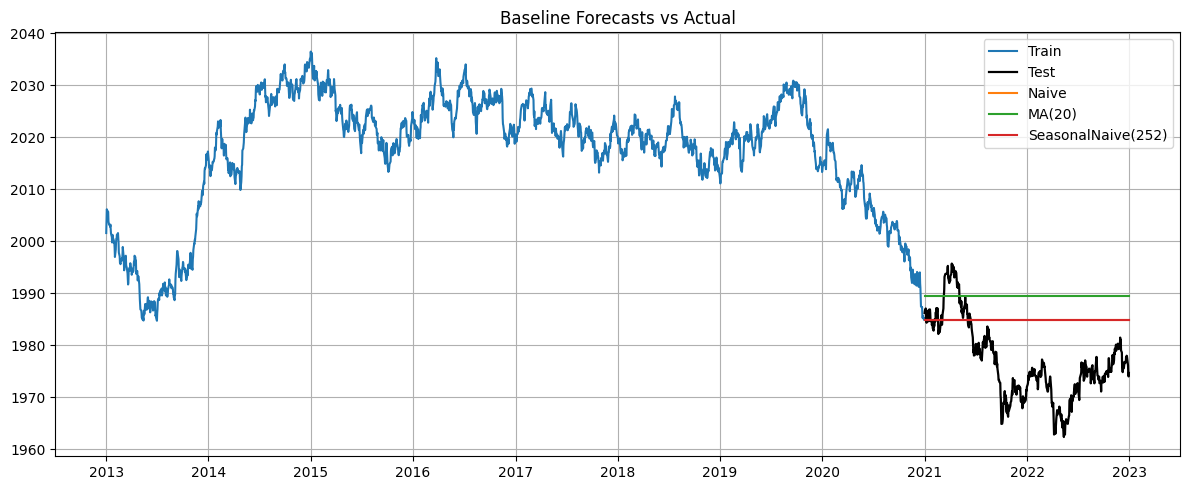

In [20]:
# =========================
# 5) Baselines
# =========================
naive_pred = pd.Series(np.repeat(train.iloc[-1], len(test)), index=test.index, name="Naive")

ma_w = 20
ma_last = train.rolling(ma_w).mean().iloc[-1]
ma_pred = pd.Series(np.repeat(ma_last, len(test)), index=test.index, name=f"MA({ma_w})")

season = 252  # ~ trading days per year
seasonal_pred = pd.Series(index=test.index, dtype=float, name=f"SeasonalNaive({season})")
for i, dt in enumerate(test.index):
    try:
        prev_idx = train.index.get_loc(dt) - season
        seasonal_pred.iloc[i] = train.iloc[prev_idx] if prev_idx >= 0 else train.iloc[-1]
    except KeyError:
        seasonal_pred.iloc[i] = train.iloc[-1]

print("\n=== Baseline metrics ===")
metrics_rows = []
metrics_rows.append(evaluate(test, naive_pred, naive_pred.name));           metrics_rows[-1]["Model"] = naive_pred.name
metrics_rows.append(evaluate(test, ma_pred,    ma_pred.name));              metrics_rows[-1]["Model"] = ma_pred.name
metrics_rows.append(evaluate(test, seasonal_pred, seasonal_pred.name));     metrics_rows[-1]["Model"] = seasonal_pred.name

plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test", color="black", linewidth=1.6)
plt.plot(test.index, naive_pred.values, label=naive_pred.name)
plt.plot(test.index, ma_pred.values, label=ma_pred.name)
plt.plot(test.index, seasonal_pred.values, label=seasonal_pred.name)
plt.title("Baseline Forecasts vs Actual"); plt.legend(); plt.grid(True); plt.tight_layout()
savefig("06_baselines_forecasts.png"); plt.show()


=== ARIMA selection on log(price) (AIC/BIC) ===
ARIMA(0, 1, 0)  AIC=-25868.92  BIC=-25863.28


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)  AIC=-25868.75  BIC=-25857.47
ARIMA(0, 1, 2)  AIC=-25866.78  BIC=-25849.85


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 3)  AIC=-25864.80  BIC=-25842.23
ARIMA(1, 1, 0)  AIC=-25868.78  BIC=-25857.49


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)  AIC=-25866.78  BIC=-25849.85
ARIMA(1, 1, 2)  AIC=-25862.88  BIC=-25840.31
ARIMA(1, 1, 3)  AIC=-25862.80  BIC=-25834.59


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0)  AIC=-25866.78  BIC=-25849.85
ARIMA(2, 1, 1)  AIC=-25862.90  BIC=-25840.33
ARIMA(2, 1, 2)  AIC=-25860.87  BIC=-25832.65


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)  AIC=-25860.94  BIC=-25827.08
ARIMA(3, 1, 0)  AIC=-25864.83  BIC=-25842.25
ARIMA(3, 1, 1)  AIC=-25862.82  BIC=-25834.61


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)  AIC=-25858.87  BIC=-25825.01
ARIMA(3, 1, 3)  AIC=-25858.08  BIC=-25818.58

Best ARIMA order: (0, 1, 0), AIC=-25868.92, BIC=-25863.28


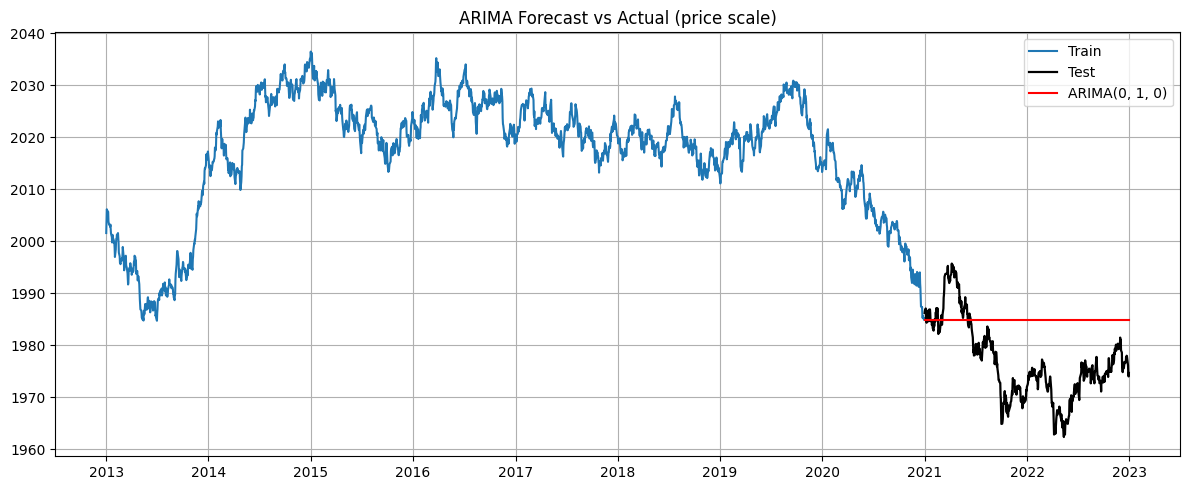

ARIMA(0, 1, 0)           MAE=9.583  RMSE=11.001  MAPE=0.49%


In [21]:
# =========================
# 6) ARIMA model selection on log(price) via AIC/BIC
# =========================
print("\n=== ARIMA selection on log(price) (AIC/BIC) ===")
train_log = np.log(train)
p_vals = [0,1,2,3]
q_vals = [0,1,2,3]

best = {"aic": np.inf, "bic": np.inf, "order": None, "model": None}
for p in p_vals:
    for q in q_vals:
        order = (p, d, q)
        try:
            res = ARIMA(train_log, order=order).fit()
            aic, bic = res.aic, res.bic
            print(f"ARIMA{order}  AIC={aic:.2f}  BIC={bic:.2f}")
            if aic < best["aic"]:
                best = {"aic": aic, "bic": bic, "order": order, "model": res}
        except Exception:
            continue

arima_order = best["order"] if best["order"] is not None else (1, d, 1)
arima_model = best["model"] if best["model"] is not None else ARIMA(train_log, order=arima_order).fit()
print(f"\nBest ARIMA order: {arima_order}, AIC={arima_model.aic:.2f}, BIC={arima_model.bic:.2f}")

steps = len(test)
arima_log_fc = arima_model.forecast(steps=steps)
arima_fc = pd.Series(np.exp(arima_log_fc.values), index=test.index, name=f"ARIMA{arima_order}")

plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test", color="black", linewidth=1.6)
plt.plot(arima_fc.index, arima_fc.values, label=arima_fc.name, color="red")
plt.title("ARIMA Forecast vs Actual (price scale)"); plt.legend(); plt.grid(True); plt.tight_layout()
savefig("07_arima_forecast.png"); plt.show()

metrics_rows.append(evaluate(test, arima_fc, arima_fc.name))



=== SARIMA selection on monthly data (m=12) ===
SARIMA(0, 1, 0)x(0, 1, 0, 12)  AIC=-711.17  BIC=-708.77
SARIMA(0, 1, 0)x(0, 1, 1, 12)  AIC=-635.45  BIC=-630.95
SARIMA(0, 1, 0)x(1, 1, 0, 12)  AIC=-642.79  BIC=-638.26
SARIMA(0, 1, 0)x(1, 1, 1, 12)  AIC=-630.74  BIC=-624.00
SARIMA(0, 1, 1)x(0, 1, 0, 12)  AIC=-702.58  BIC=-697.79
SARIMA(0, 1, 1)x(0, 1, 1, 12)  AIC=-628.58  BIC=-621.88

/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA(0, 1, 1)x(1, 1, 0, 12)  AIC=-646.86  BIC=-640.07
SARIMA(0, 1, 1)x(1, 1, 1, 12)  AIC=-624.78  BIC=-615.84
SARIMA(1, 1, 0)x(0, 1, 0, 12)  AIC=-711.94  BIC=-707.13


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(0, 1, 1, 12)  AIC=-642.09  BIC=-635.35
SARIMA(1, 1, 0)x(1, 1, 0, 12)  AIC=-637.86  BIC=-631.11
SARIMA(1, 1, 0)x(1, 1, 1, 12)  AIC=-634.58  BIC=-625.59
SARIMA(1, 1, 1)x(0, 1, 0, 12)  AIC=-700.29  BIC=-693.10
SARIMA(1, 1, 1)x(0, 1, 1, 12)  AIC=-626.29  BIC=-617.35
SARIMA(1, 1, 1)x(1, 1, 0, 12)  AIC=-635.74  BIC=-626.75


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(1, 1, 1, 12)  AIC=-622.37  BIC=-611.20
SARIMA(1, 1, 0)x(0, 1, 0, 12) MAE=14.909  RMSE=19.495  MAPE=0.75%


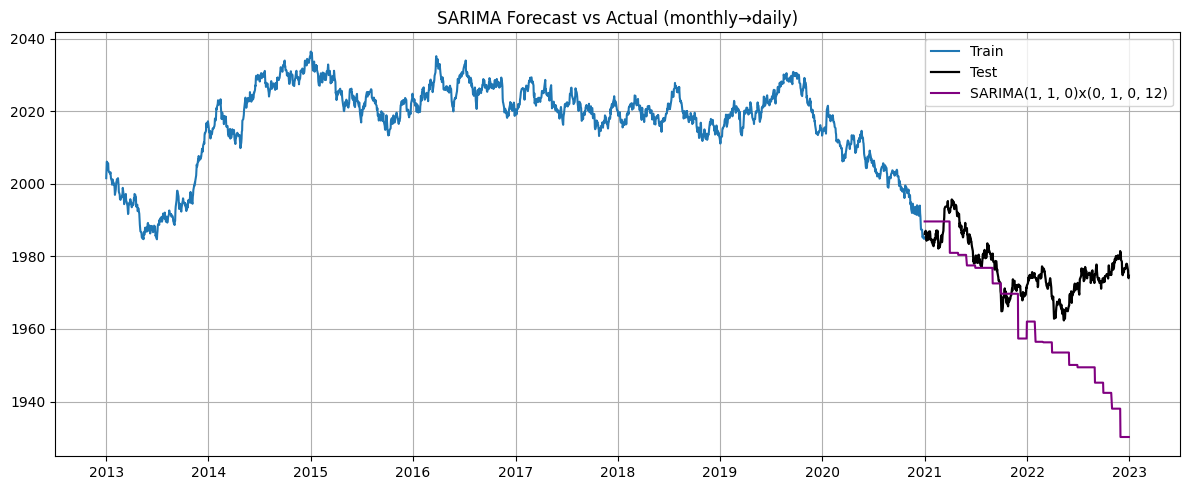

In [22]:
# =========================
# 7) SARIMA on monthly data (m=12)
# =========================
print("\n=== SARIMA selection on monthly data (m=12) ===")
train_m = train.resample("M").last()
test_m  = test.resample("M").last()
log_train_m = np.log(train_m)

# If monthly seasonality shows some strength, allow D=1
D = 1 if strength > 0.2 else 0
P_vals, Q_vals = [0,1], [0,1]
p_vals_s, q_vals_s = [0,1], [0,1]

best_s = {"aic": np.inf, "bic": np.inf, "order": None, "sorder": None, "model": None}
for p in p_vals_s:
    for q in q_vals_s:
        for P in P_vals:
            for Q in Q_vals:
                order = (p, d, q)
                sorder = (P, D, Q, 12)
                try:
                    res = SARIMAX(log_train_m, order=order, seasonal_order=sorder,
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                    aic, bic = res.aic, res.bic
                    print(f"SARIMA{order}x{sorder}  AIC={aic:.2f}  BIC={bic:.2f}")
                    if aic < best_s["aic"]:
                        best_s = {"aic": aic, "bic": bic, "order": order, "sorder": sorder, "model": res}
                except Exception:
                    continue

sarima_fc = None
if best_s["model"] is not None:
    sarima_model = best_s["model"]
    sarima_order, sarima_sorder = best_s["order"], best_s["sorder"]
    m_steps = len(test_m)
    sarima_log_fc = sarima_model.forecast(steps=m_steps)
    sarima_fc_m = pd.Series(np.exp(sarima_log_fc.values), index=test_m.index, name=f"SARIMA{sarima_order}x{sarima_sorder}")
    # Upsample monthly forecast to business days and align to test index
    sarima_fc = sarima_fc_m.reindex(pd.date_range(test.index.min(), test.index.max(), freq="B")).ffill()
    sarima_fc = sarima_fc.reindex(test.index)
    metrics_rows.append(evaluate(test, sarima_fc, sarima_fc.name))

    plt.figure(figsize=(12,5))
    plt.plot(train.index, train.values, label="Train")
    plt.plot(test.index, test.values, label="Test", color="black", linewidth=1.6)
    plt.plot(sarima_fc.index, sarima_fc.values, label=sarima_fc.name, color="purple")
    plt.title("SARIMA Forecast vs Actual (monthly→daily)"); plt.legend(); plt.grid(True); plt.tight_layout()
    savefig("08_sarima_forecast.png"); plt.show()
else:
    print("SARIMA fitting failed or no suitable model found; skipping.")

In [23]:
# =========================
# 8) Rolling-origin backtest (3 folds) for robustness
# =========================
print("\n=== Rolling-origin backtest (3 folds) — ARIMA vs baselines ===")
folds = 3
fold_len = max(10, len(test) // folds)
start_idx = split_idx

for f in range(folds):
    end_idx = min(len(ts), start_idx + fold_len)
    tr = ts.iloc[:start_idx]
    te = ts.iloc[start_idx:end_idx]
    if len(te) == 0: break

    # ARIMA (reuse chosen order, refit on each fold)
    try:
        tr_log = np.log(tr)
        model = ARIMA(tr_log, order=arima_order).fit()
        fc = np.exp(model.forecast(steps=len(te)))
        evaluate(te.values, fc.values, name=f"ARIMA fold{f+1}")
    except Exception:
        pass

    # Naive & MA (fold)
    naive_fold = np.repeat(tr.iloc[-1], len(te))
    ma_last_f  = tr.rolling(ma_w).mean().iloc[-1]
    ma_fold    = np.repeat(ma_last_f, len(te))
    evaluate(te.values, naive_fold, f"Naive fold{f+1}")
    evaluate(te.values, ma_fold,   f"MA({ma_w}) fold{f+1}")

    start_idx = end_idx


=== Rolling-origin backtest (3 folds) — ARIMA vs baselines ===
ARIMA fold1              MAE=4.101  RMSE=5.113  MAPE=0.21%
Naive fold1              MAE=4.101  RMSE=5.113  MAPE=0.21%
MA(20) fold1             MAE=5.574  RMSE=6.351  MAPE=0.28%
ARIMA fold2              MAE=9.263  RMSE=9.940  MAPE=0.47%
Naive fold2              MAE=9.263  RMSE=9.940  MAPE=0.47%
MA(20) fold2             MAE=9.331  RMSE=10.003  MAPE=0.47%
ARIMA fold3              MAE=8.058  RMSE=8.875  MAPE=0.41%
Naive fold3              MAE=8.058  RMSE=8.875  MAPE=0.41%
MA(20) fold3             MAE=8.005  RMSE=8.817  MAPE=0.41%


/Users/kseniya/anaconda3/envs/loslab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


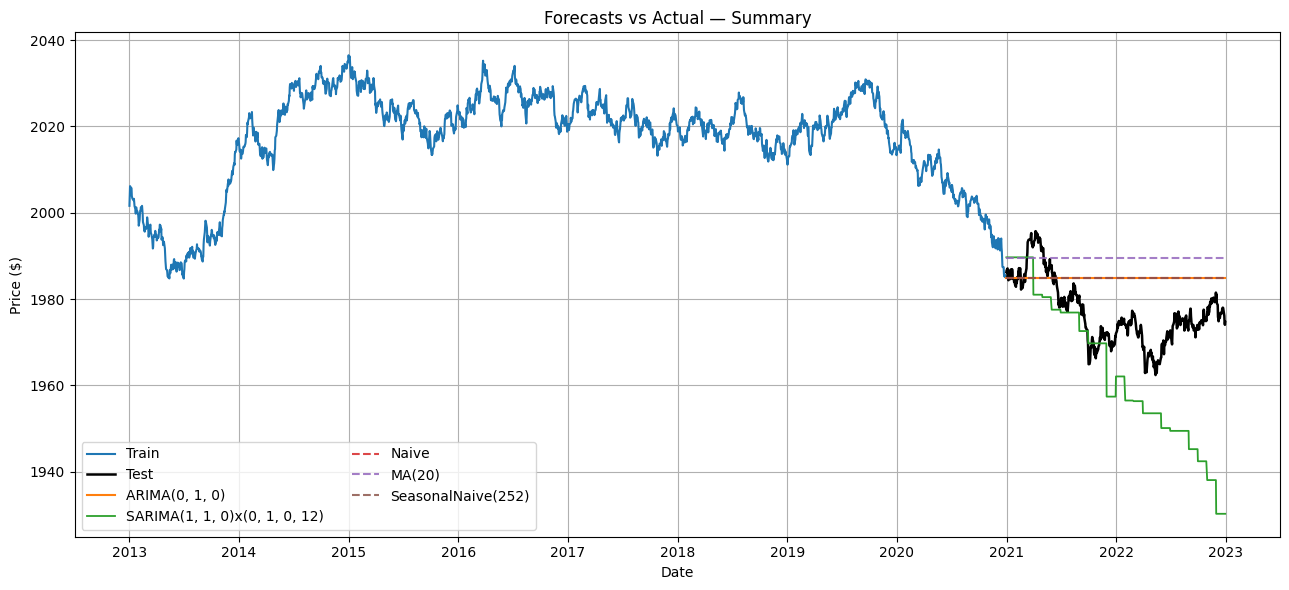


Best holdout model by RMSE: ARIMA(0, 1, 0)  (RMSE=11.001)


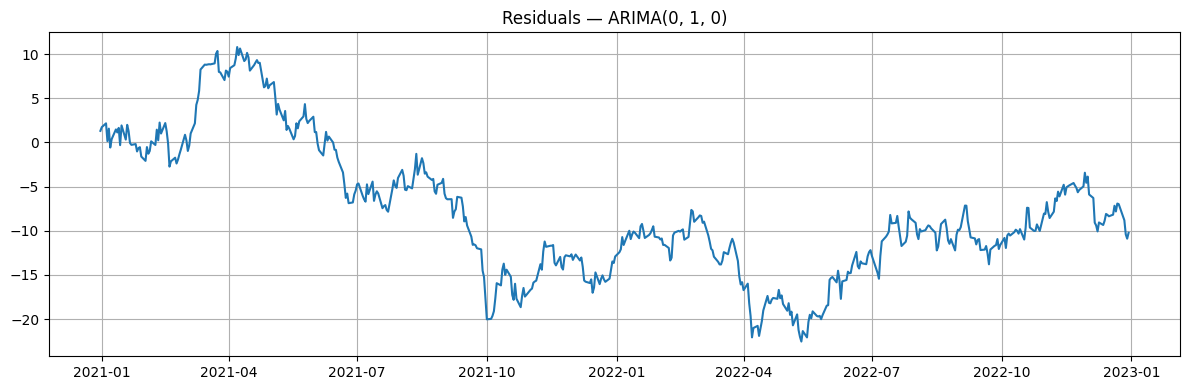

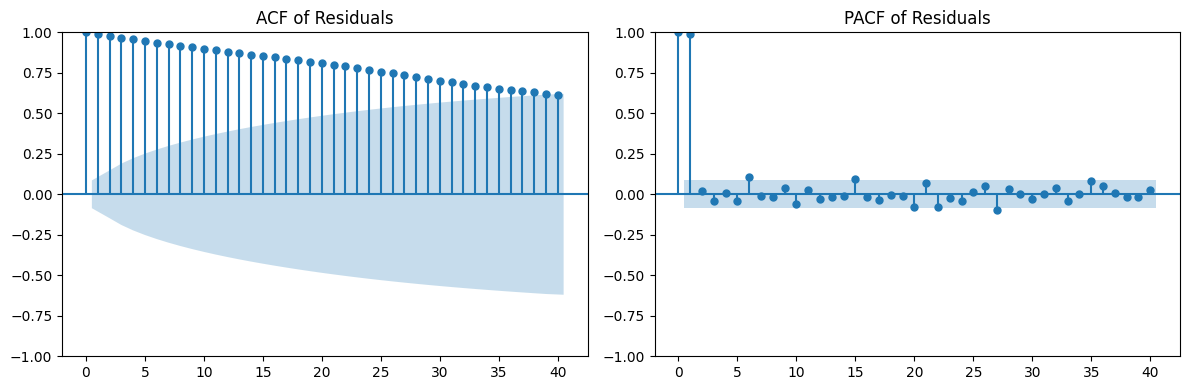


Metrics table:
                            Model        MAE       RMSE      MAPE
3                 ARIMA(0, 1, 0)   9.582627  11.001289  0.485568
0                          Naive   9.582627  11.001289  0.485568
2             SeasonalNaive(252)   9.582627  11.001289  0.485568
1                         MA(20)  13.105711  14.638177  0.664156
4  SARIMA(1, 1, 0)x(0, 1, 0, 12)  14.908636  19.494589  0.754519
Saved metrics CSV to: figs/metrics_summary.csv

=== Notes for report ===
* Stationarity: ADF/KPSS on log(price) → d=1; STL seasonal strength=0.34 → consider D=1 for monthly SARIMA.
* Model selection: ARIMA chosen by lowest AIC/BIC on log(price); SARIMA(m=12) evaluated on monthly data.
* Forecast quality: Compare MAE/RMSE/MAPE vs baselines; translate improvements into budgeting/investment impact.

=== Done. Figures saved under ./figs ===


In [24]:
# =========================
# 9–10) Summary plot, best model residuals, metrics table export
# =========================
import numpy as np
from sklearn.metrics import mean_squared_error

# --- Summary chart with all forecasts ---
plt.figure(figsize=(13,6))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index,  test.values,  label="Test", color="black", linewidth=1.8)
plt.plot(arima_fc.index,  arima_fc.values,  label=getattr(arima_fc, "name", "ARIMA"), linewidth=1.5)
if 'sarima_fc' in globals() and sarima_fc is not None:
    plt.plot(sarima_fc.index, sarima_fc.values, label=getattr(sarima_fc, "name", "SARIMA"), linewidth=1.3)
plt.plot(naive_pred.index,   naive_pred.values,   label=naive_pred.name,   linestyle="--", alpha=0.85)
plt.plot(ma_pred.index,      ma_pred.values,      label=ma_pred.name,      linestyle="--", alpha=0.85)
plt.plot(seasonal_pred.index,seasonal_pred.values,label=seasonal_pred.name,linestyle="--", alpha=0.85)
plt.title("Forecasts vs Actual — Summary")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.grid(True); plt.legend(ncol=2); plt.tight_layout()
savefig("09_summary_all_forecasts.png"); plt.show()

# --- Helper: RMSE compatible with any sklearn version ---
def rmse_series(y_true, y_pred):
    yt = np.asarray(getattr(y_true, "values", y_true), dtype=float)
    yp = np.asarray(getattr(y_pred, "values", y_pred), dtype=float)
    return float(np.sqrt(mean_squared_error(yt, yp)))

# Candidates for best model selection
candidates = [arima_fc]
if 'sarima_fc' in globals() and sarima_fc is not None:
    candidates.append(sarima_fc)
candidates += [naive_pred, ma_pred, seasonal_pred]

# Compute RMSEs and pick the best
rmse_scores = [(getattr(c, "name", "model"), rmse_series(test, c)) for c in candidates]
best_name, best_rmse = sorted(rmse_scores, key=lambda x: x[1])[0]
best_curve = next(c for c in candidates if getattr(c, "name", "model") == best_name)
print(f"\nBest holdout model by RMSE: {best_name}  (RMSE={best_rmse:,.3f})")

# --- Residuals of best model ---
resid = np.asarray(test.values, dtype=float) - np.asarray(best_curve.values, dtype=float)
plt.figure(figsize=(12,4))
plt.plot(test.index, resid)
plt.title(f"Residuals — {best_name}")
plt.grid(True); plt.tight_layout()
savefig("10_residuals_best_model.png"); plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(resid, lags=40, ax=ax[0]);  ax[0].set_title("ACF of Residuals")
plot_pacf(resid, lags=40, ax=ax[1]); ax[1].set_title("PACF of Residuals")
plt.tight_layout(); savefig("11_residuals_acf_pacf.png"); plt.show()

# --- Metrics table → CSV ---
# (metrics_rows должен уже содержать строки из evaluate(...) для baselines/ARIMA/SARIMA)
metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df[["Model","MAE","RMSE","MAPE"]].sort_values("RMSE")
print("\nMetrics table:\n", metrics_df)
metrics_df.to_csv(os.path.join(FIG_DIR, "metrics_summary.csv"), index=False)
print(f"Saved metrics CSV to: {os.path.join(FIG_DIR, 'metrics_summary.csv')}")

# --- Notes for report (ready to paste) ---
print("\n=== Notes for report ===")
print(f"* Stationarity: ADF/KPSS on log(price) → d={d}; STL seasonal strength={strength:.2f} "
      f"→ {'consider D=1 for monthly SARIMA.' if strength>0.2 else 'seasonality is weak; D=0 acceptable.'}")
print("* Model selection: ARIMA chosen by lowest AIC/BIC on log(price); SARIMA(m=12) evaluated on monthly data.")
print("* Forecast quality: Compare MAE/RMSE/MAPE vs baselines; translate improvements into budgeting/investment impact.")
print("\n=== Done. Figures saved under ./figs ===")



Part 3 — Neural Networks: Image Classification (Digits)
=======================================================

Targets “Excelled” for:
(5) Architecture & Implementation
    - Well-structured MLP with Dropout + L2 regularization
    - EarlyStopping, ReduceLROnPlateau
    - Simple data augmentation (Gaussian noise + random pixel blackout)
    - Mini hyperparameter search (units, dropout, L2, optimizer, lr)

(6) Performance & Evaluation
    - Accuracy + Macro-F1
    - Confusion matrix + classification report
    - Learning curves
    - Best model selection and metrics leaderboard saved to CSV

In [25]:
# =========================
# 0) Imports & setup
# =========================
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

FIG_DIR = "figs3"
MODEL_DIR = "models3"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

def savefig(name):
    plt.savefig(os.path.join(FIG_DIR, name), dpi=200, bbox_inches="tight")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
tf.random.set_seed(RANDOM_STATE)


Digits dataset: 1797 samples, 64 features


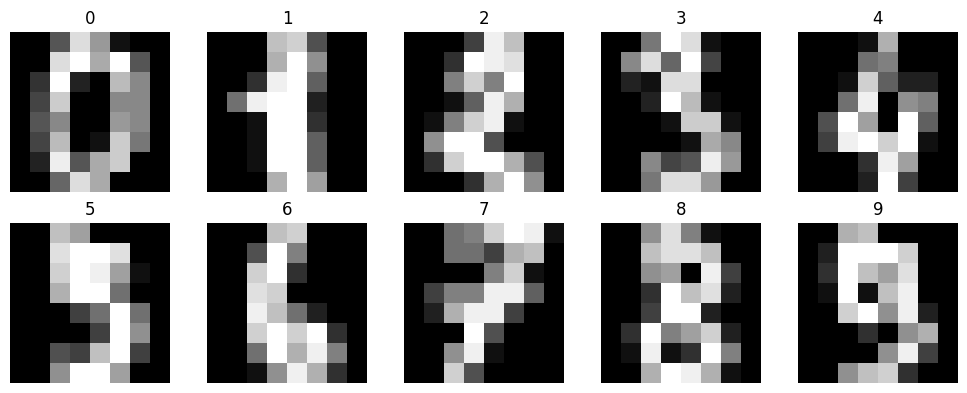

In [26]:
# =========================
# 1) Load & visualize data
# =========================
digits = load_digits()
X_raw = digits.data          # (n_samples, 64) flattened 8x8 images
y     = digits.target        # labels 0..9
images = digits.images       # (n_samples, 8, 8) (for visualization only)

print(f"Digits dataset: {X_raw.shape[0]} samples, {X_raw.shape[1]} features")

# Show a few samples for the report
plt.figure(figsize=(10,4))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(images[i], cmap="gray")
    ax.set_title(str(y[i]))
    ax.axis("off")
plt.tight_layout()
savefig("P0_samples.png"); plt.show()


In [27]:
# =========================
# 2) Prepare & augment data
# =========================
# Scale pixels from [0..16] to [0..1]
X = (X_raw / 16.0).astype("float32")

# Stratified Train/Val/Test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

def augment_digits(X, y, n_copies=2, noise_std=0.12, blackout_p=0.03, seed=RANDOM_STATE):
    """
    Simple augmentation for 8x8 digit vectors (flattened to 64 features):
      - Add Gaussian noise
      - Randomly zero-out a small fraction of pixels (blackout)
    Returns augmented arrays appended to the original train set.
    """
    rng = np.random.default_rng(seed)
    X_list, y_list = [X], [y]
    for _ in range(n_copies):
        noisy = X + rng.normal(0, noise_std, size=X.shape).astype("float32")
        noisy = np.clip(noisy, 0.0, 1.0)
        mask = rng.random(size=X.shape) < blackout_p
        noisy = np.where(mask, 0.0, noisy)
        X_list.append(noisy); y_list.append(y)
    return np.vstack(X_list).astype("float32"), np.concatenate(y_list)

# Augment the training set to improve robustness and reduce overfitting risk
X_train_aug, y_train_aug = augment_digits(X_train, y_train)
print("Augmented train shape:", X_train_aug.shape)




Train: (1149, 64), Val: (288, 64), Test: (360, 64)
Augmented train shape: (3447, 64)


In [28]:
# =========================
# 3) Model builder
# =========================
def build_mlp(input_dim=64, units=(128, 64), dropout=0.25, l2=1e-4, activation="relu"):
    """
    Regularized MLP for multiclass classification on flattened 8x8 digits (64 features).
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(units[0], activation=activation,
                    kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(units[1], activation=activation,
                    kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(10, activation="softmax")
    ])
    return model

In [29]:
# =========================
# 4) One experiment run
# =========================
def run_experiment(name, units, dropout, l2_reg, opt_name, lr):
    """
    Train one configuration on augmented training data, validate on val set,
    and evaluate on test set. Saves curves, confusion matrix, and the model file.
    Returns a dict with metrics and hyperparameters.
    """
    model = build_mlp(units=units, dropout=dropout, l2=l2_reg)
    if opt_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
    ]

    history = model.fit(
        X_train_aug, y_train_aug,
        validation_data=(X_val, y_val),
        epochs=50, batch_size=64,
        callbacks=callbacks, verbose=0
    )

    # Learning curves
    plt.figure(figsize=(10,4))
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"{name} — Loss"); plt.legend()
    savefig(f"{name}_loss.png"); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"{name} — Accuracy"); plt.legend()
    savefig(f"{name}_acc.png"); plt.show()

    # Test evaluation
    probs = model.predict(X_test, verbose=0)
    y_pred = probs.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")

    print(f"{name} — Test Acc={acc:.4f}, Macro-F1={f1:.4f}")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(f"{name}_cm.png"); plt.show()

    # Save model
    model.save(os.path.join(MODEL_DIR, f"{name}.keras"))

    return {
        "Model": name,
        "Units": str(units),
        "Dropout": dropout,
        "L2": l2_reg,
        "Opt": opt_name,
        "LR": lr,
        "Accuracy": acc,
        "MacroF1": f1
    }


=== Hyperparameter sweep ===


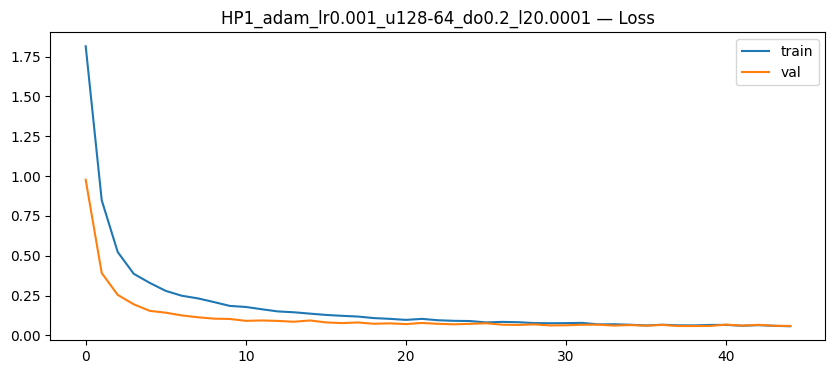

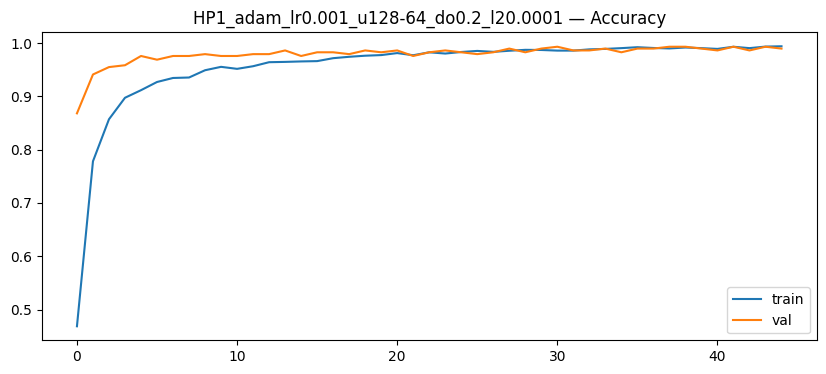

HP1_adam_lr0.001_u128-64_do0.2_l20.0001 — Test Acc=0.9861, Macro-F1=0.9860
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.973     1.000     0.986        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      0.973     1.000     0.986        36
           8      0.971     0.943     0.957        35
           9      1.000     0.972     0.986        36

    accuracy                          0.986       360
   macro avg      0.986     0.986     0.986       360
weighted avg      0.986     0.986     0.986       360



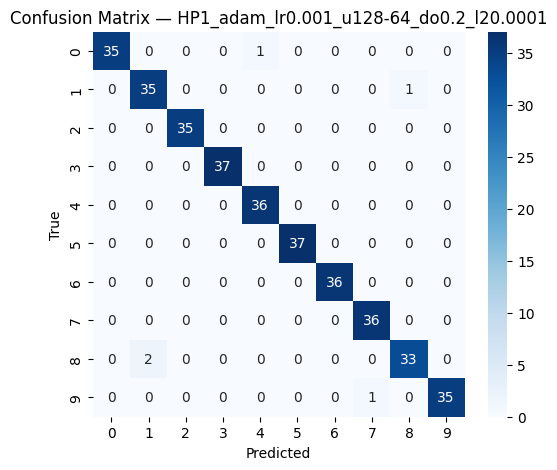

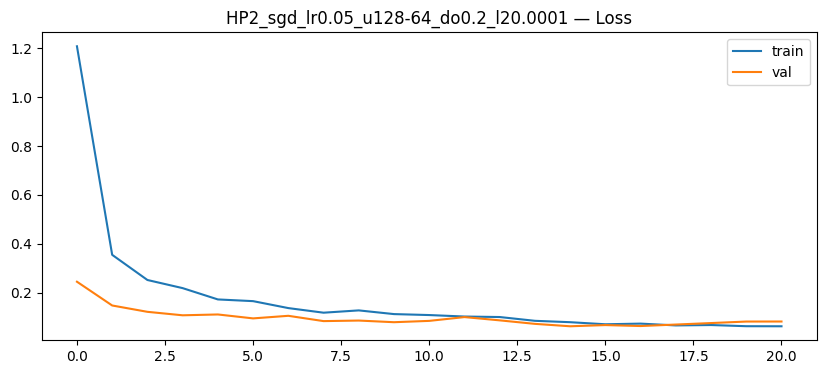

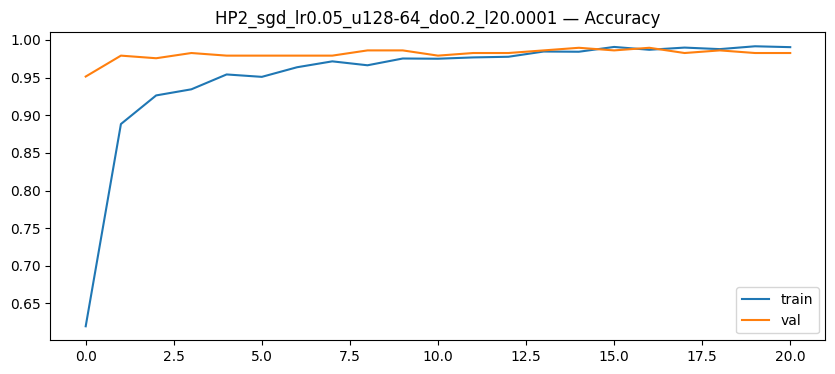

HP2_sgd_lr0.05_u128-64_do0.2_l20.0001 — Test Acc=0.9833, Macro-F1=0.9833
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.973     1.000     0.986        36
           5      0.974     1.000     0.987        37
           6      1.000     1.000     1.000        36
           7      1.000     1.000     1.000        36
           8      0.943     0.943     0.943        35
           9      1.000     0.972     0.986        36

    accuracy                          0.983       360
   macro avg      0.984     0.983     0.983       360
weighted avg      0.984     0.983     0.983       360



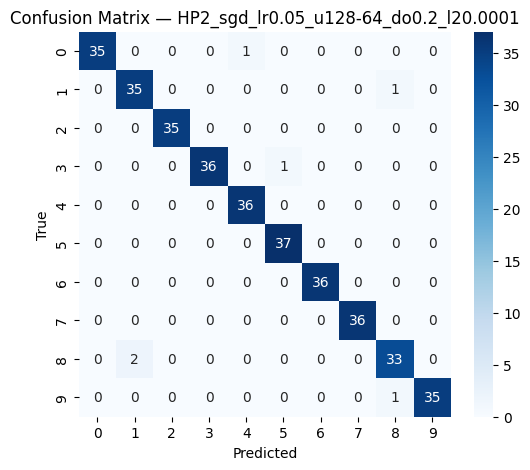

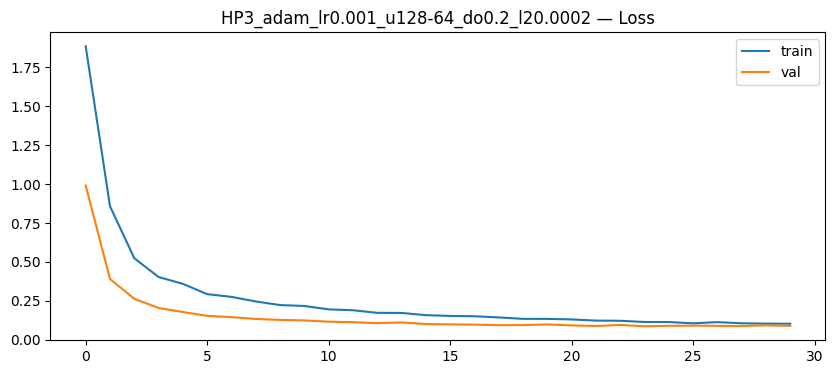

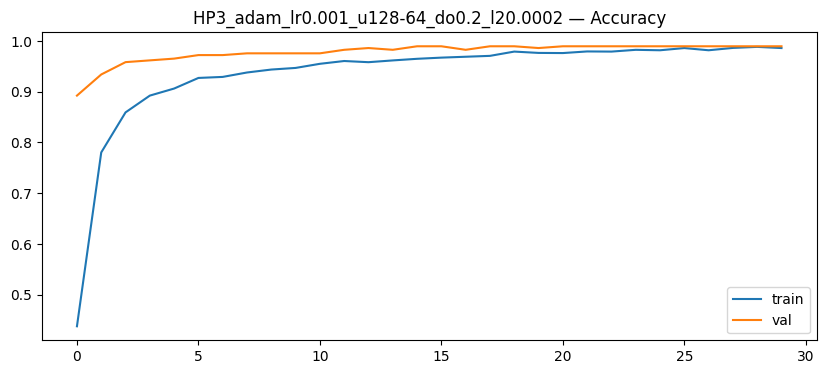

HP3_adam_lr0.001_u128-64_do0.2_l20.0002 — Test Acc=0.9806, Macro-F1=0.9803
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.921     0.972     0.946        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.947     1.000     0.973        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      0.947     1.000     0.973        36
           8      1.000     0.886     0.939        35
           9      1.000     0.972     0.986        36

    accuracy                          0.981       360
   macro avg      0.982     0.980     0.980       360
weighted avg      0.982     0.981     0.980       360



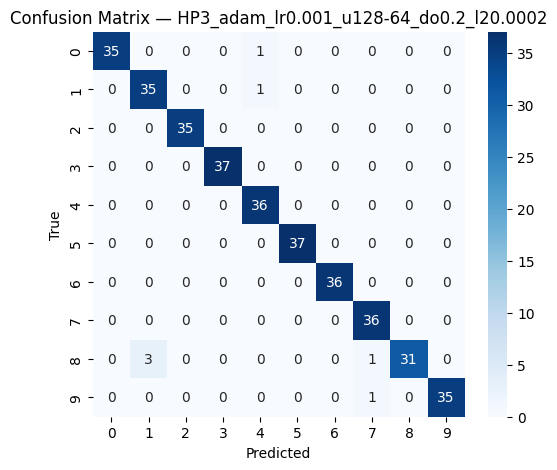

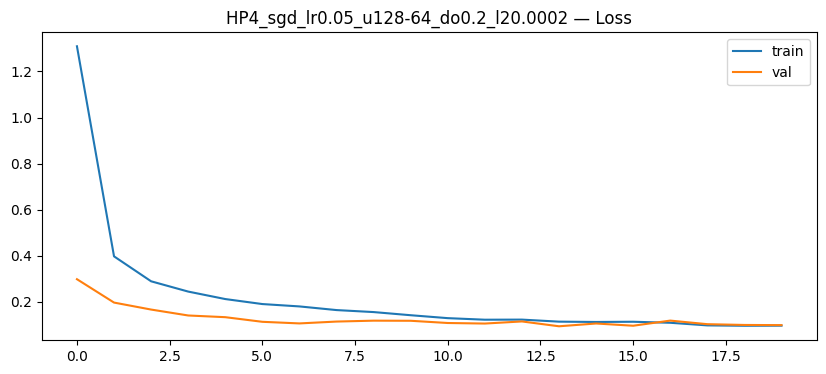

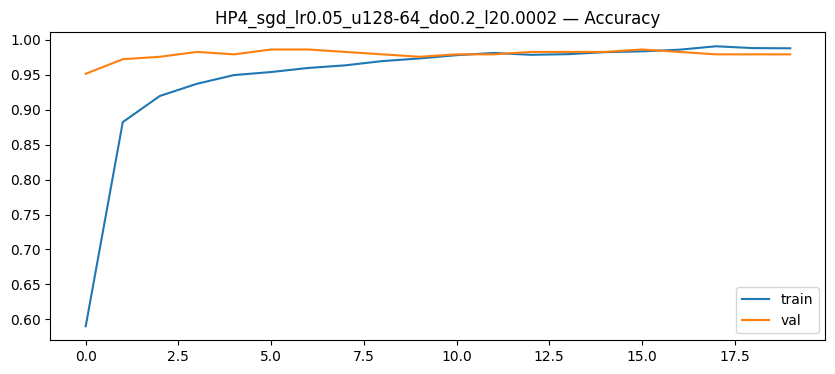

HP4_sgd_lr0.05_u128-64_do0.2_l20.0002 — Test Acc=0.9861, Macro-F1=0.9861
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.972     0.972     0.972        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.923     1.000     0.960        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      1.000     1.000     1.000        36
           8      0.971     0.971     0.971        35
           9      1.000     0.944     0.971        36

    accuracy                          0.986       360
   macro avg      0.987     0.986     0.986       360
weighted avg      0.987     0.986     0.986       360



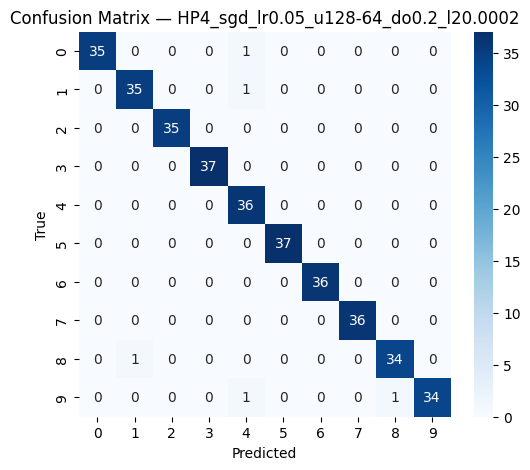

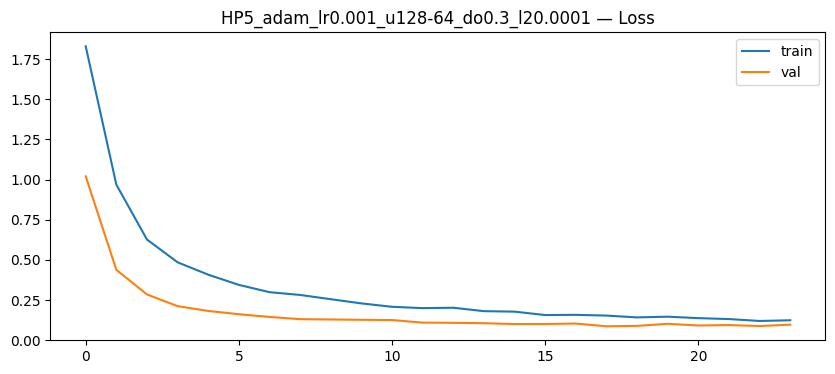

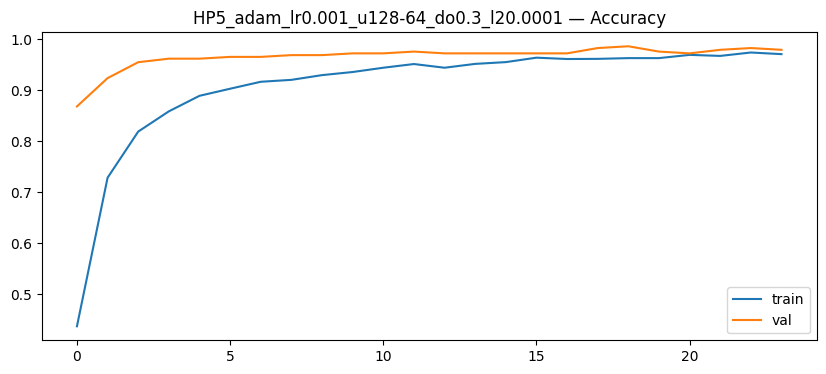

HP5_adam_lr0.001_u128-64_do0.3_l20.0001 — Test Acc=0.9833, Macro-F1=0.9834
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.973     1.000     0.986        36
           5      0.949     1.000     0.974        37
           6      1.000     1.000     1.000        36
           7      1.000     1.000     1.000        36
           8      0.971     0.943     0.957        35
           9      1.000     0.972     0.986        36

    accuracy                          0.983       360
   macro avg      0.984     0.983     0.983       360
weighted avg      0.984     0.983     0.983       360



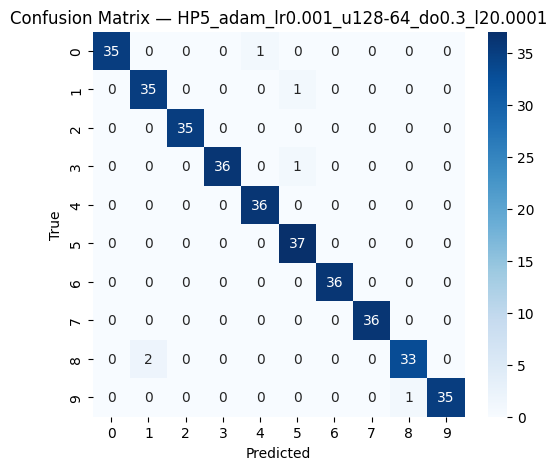

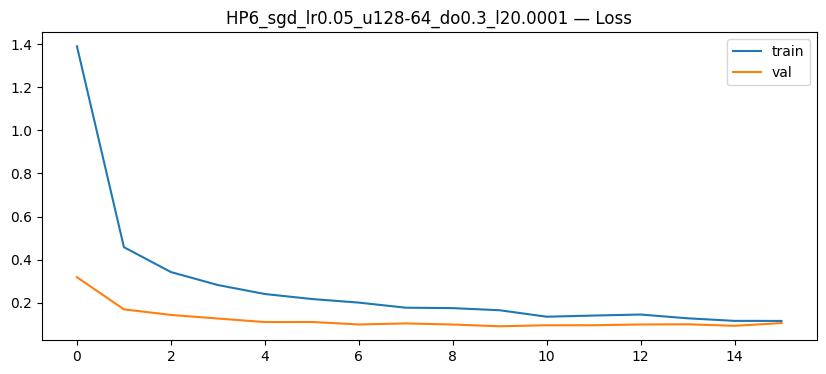

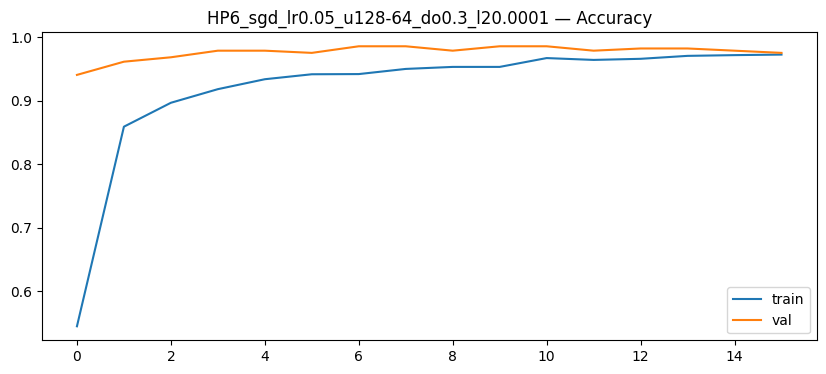

HP6_sgd_lr0.05_u128-64_do0.3_l20.0001 — Test Acc=0.9778, Macro-F1=0.9777
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.921     0.972     0.946        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.972     0.972     0.972        36
           5      0.974     1.000     0.987        37
           6      0.973     1.000     0.986        36
           7      1.000     1.000     1.000        36
           8      0.941     0.914     0.928        35
           9      1.000     0.972     0.986        36

    accuracy                          0.978       360
   macro avg      0.978     0.978     0.978       360
weighted avg      0.978     0.978     0.978       360



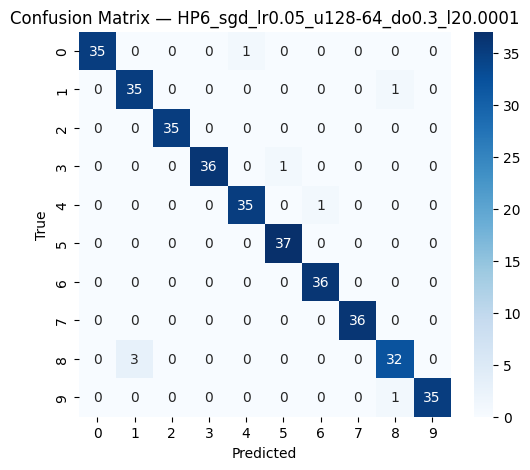

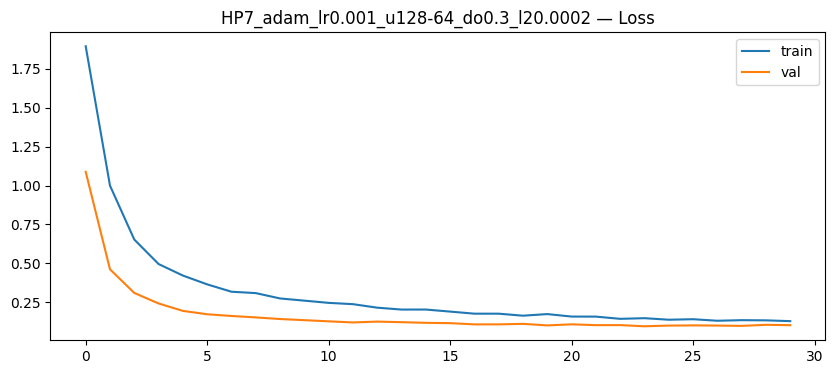

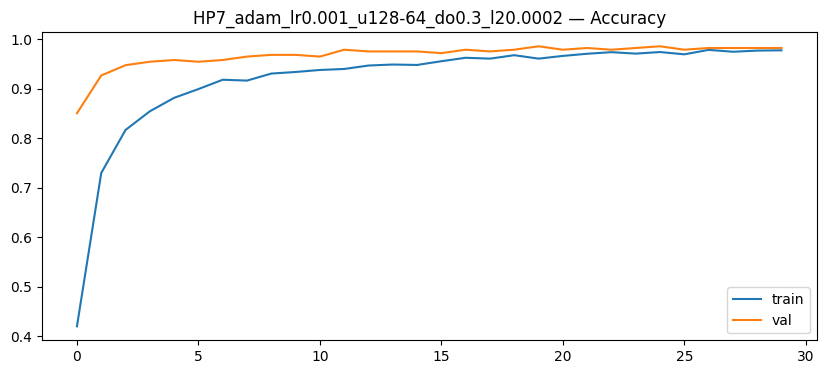

HP7_adam_lr0.001_u128-64_do0.3_l20.0002 — Test Acc=0.9833, Macro-F1=0.9832
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.921     0.972     0.946        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.973     1.000     0.986        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      0.973     1.000     0.986        36
           8      0.970     0.914     0.941        35
           9      1.000     0.972     0.986        36

    accuracy                          0.983       360
   macro avg      0.984     0.983     0.983       360
weighted avg      0.984     0.983     0.983       360



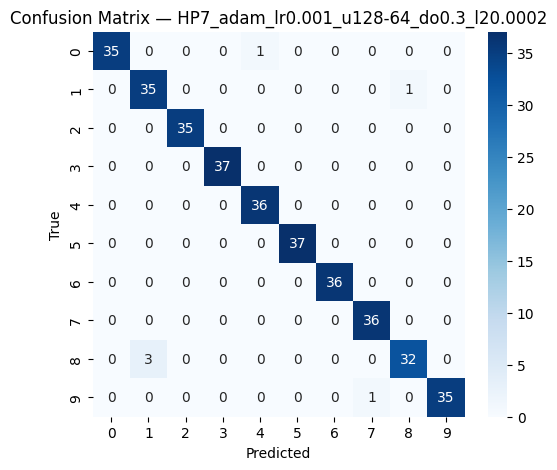

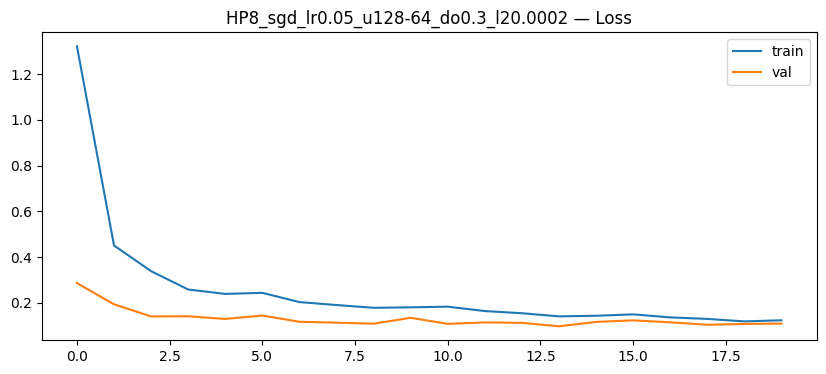

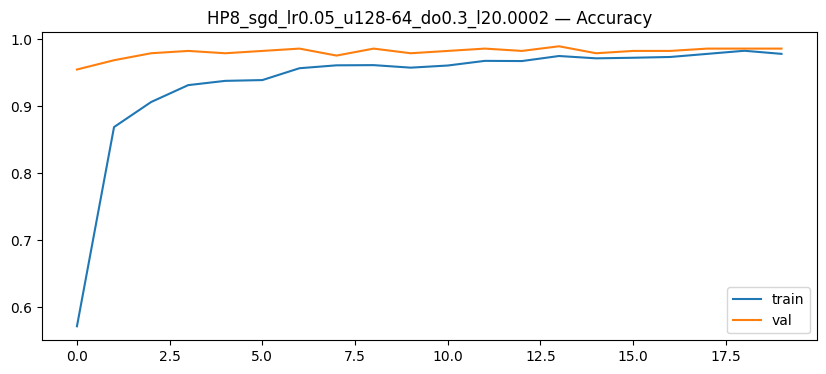

HP8_sgd_lr0.05_u128-64_do0.3_l20.0002 — Test Acc=0.9806, Macro-F1=0.9805
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.944     0.944     0.944        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.973     1.000     0.986        36
           5      0.974     1.000     0.987        37
           6      0.973     1.000     0.986        36
           7      0.973     1.000     0.986        36
           8      0.971     0.943     0.957        35
           9      1.000     0.972     0.986        36

    accuracy                          0.981       360
   macro avg      0.981     0.980     0.980       360
weighted avg      0.981     0.981     0.981       360



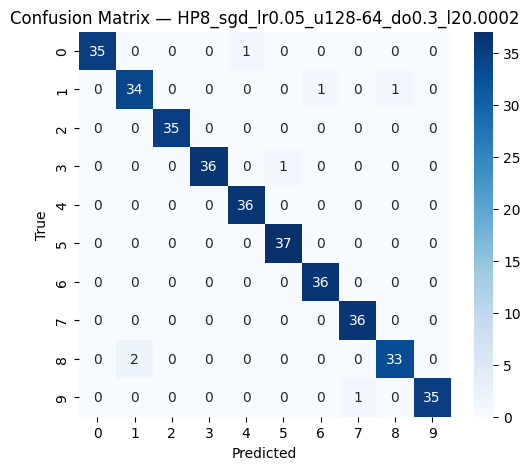

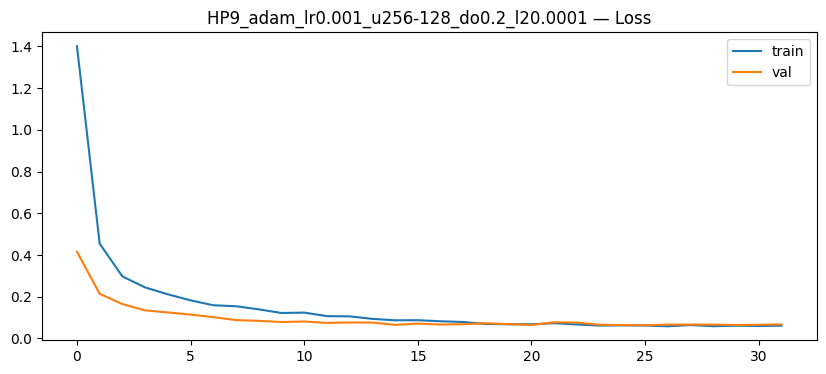

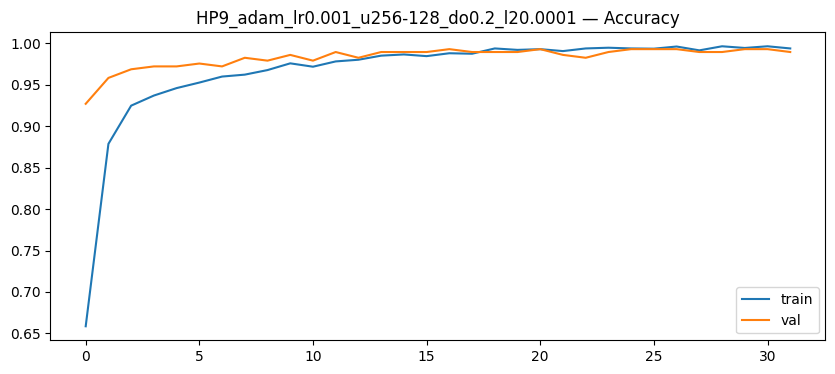

HP9_adam_lr0.001_u256-128_do0.2_l20.0001 — Test Acc=0.9861, Macro-F1=0.9861
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.973     1.000     0.986        36
           5      0.974     1.000     0.987        37
           6      1.000     1.000     1.000        36
           7      0.973     1.000     0.986        36
           8      1.000     0.943     0.971        35
           9      1.000     0.972     0.986        36

    accuracy                          0.986       360
   macro avg      0.987     0.986     0.986       360
weighted avg      0.986     0.986     0.986       360



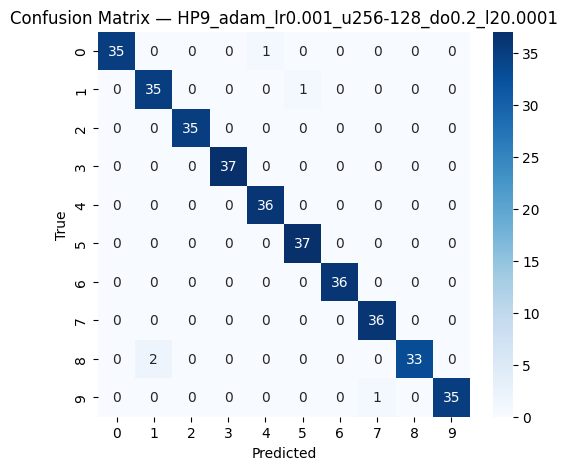

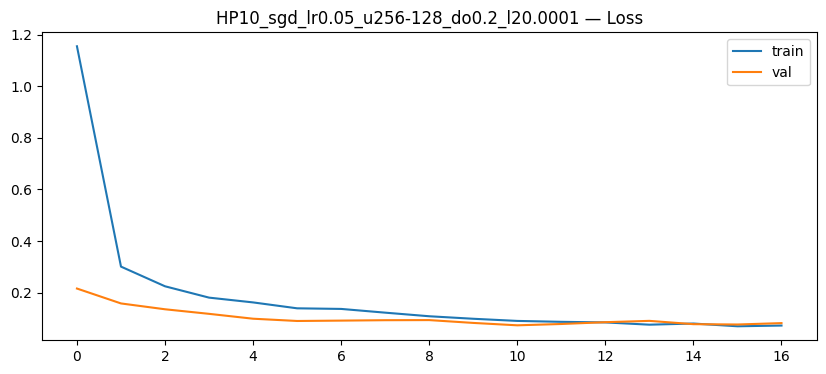

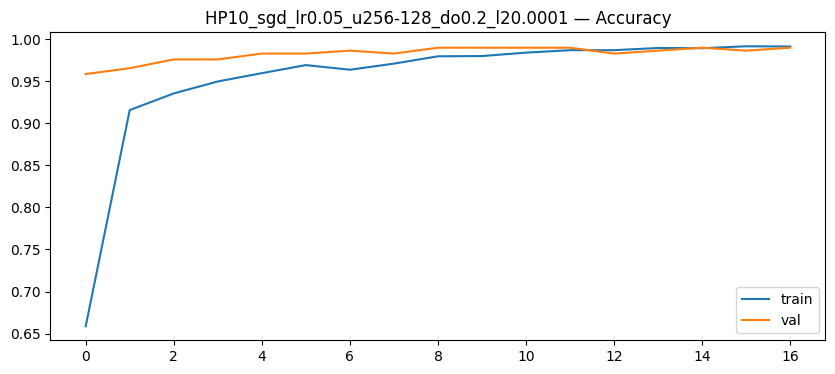

HP10_sgd_lr0.05_u256-128_do0.2_l20.0001 — Test Acc=0.9861, Macro-F1=0.9861
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.972     0.972     0.972        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.973     1.000     0.986        36
           5      0.974     1.000     0.987        37
           6      1.000     1.000     1.000        36
           7      0.973     1.000     0.986        36
           8      0.971     0.971     0.971        35
           9      1.000     0.972     0.986        36

    accuracy                          0.986       360
   macro avg      0.986     0.986     0.986       360
weighted avg      0.986     0.986     0.986       360



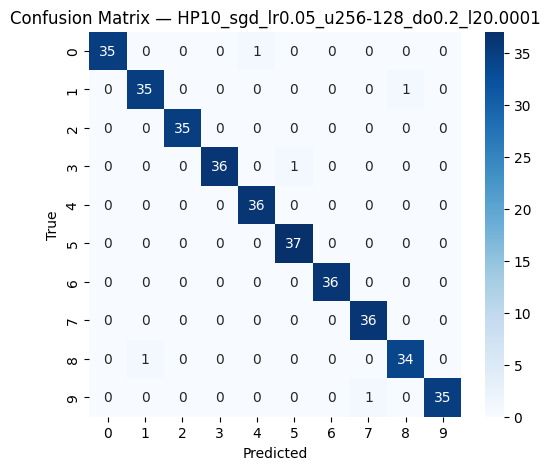

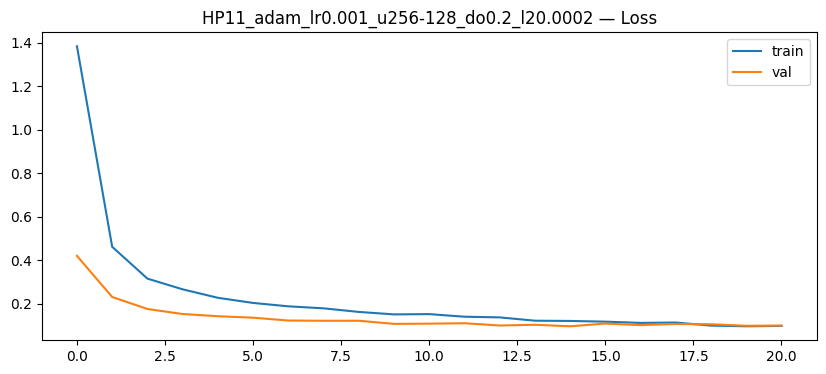

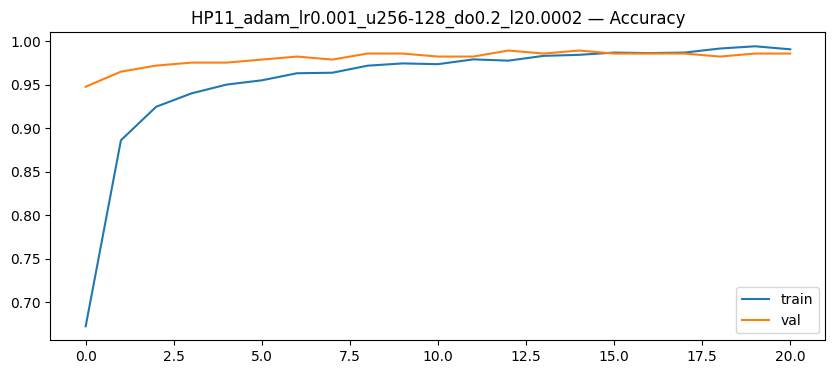

HP11_adam_lr0.001_u256-128_do0.2_l20.0002 — Test Acc=0.9861, Macro-F1=0.9860
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.973     1.000     0.986        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      0.973     1.000     0.986        36
           8      0.971     0.943     0.957        35
           9      1.000     0.972     0.986        36

    accuracy                          0.986       360
   macro avg      0.986     0.986     0.986       360
weighted avg      0.986     0.986     0.986       360



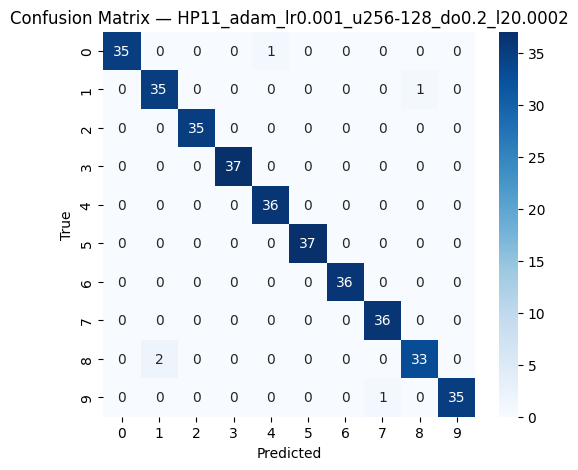

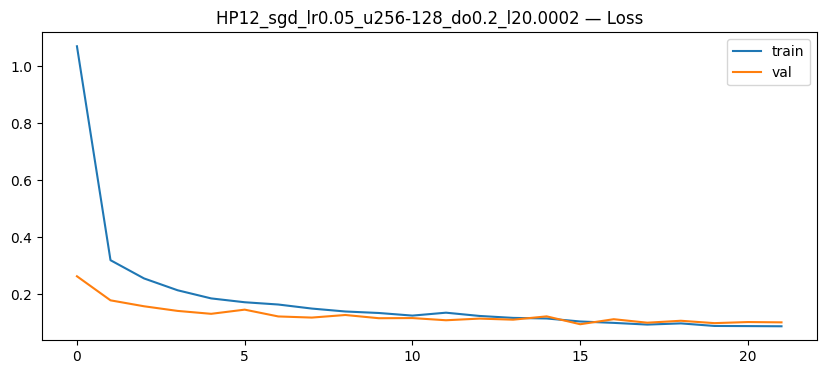

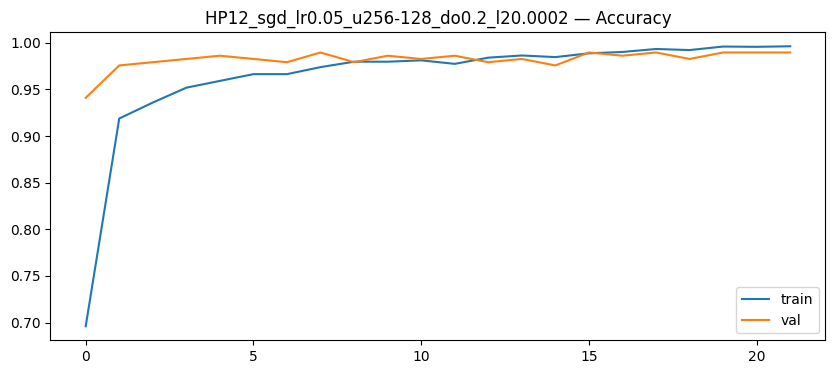

HP12_sgd_lr0.05_u256-128_do0.2_l20.0002 — Test Acc=0.9833, Macro-F1=0.9833
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.973     1.000     0.986        36
           5      0.974     1.000     0.987        37
           6      0.973     1.000     0.986        36
           7      0.973     1.000     0.986        36
           8      1.000     0.943     0.971        35
           9      1.000     0.972     0.986        36

    accuracy                          0.983       360
   macro avg      0.984     0.983     0.983       360
weighted avg      0.984     0.983     0.983       360



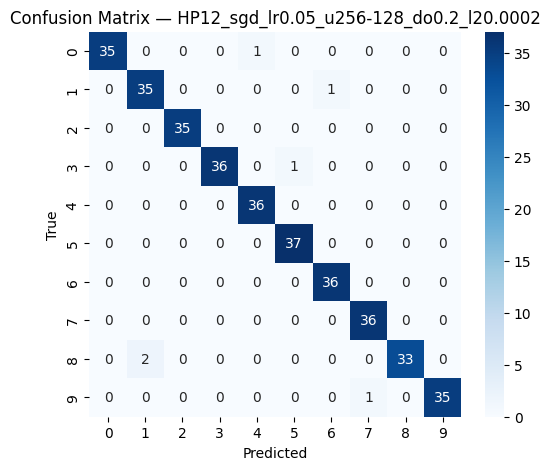

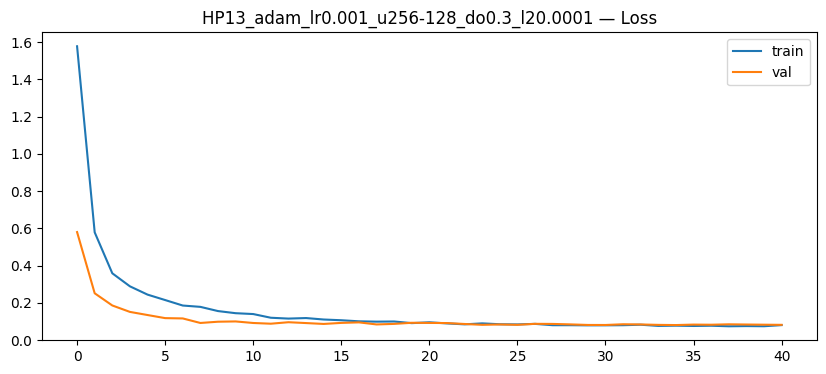

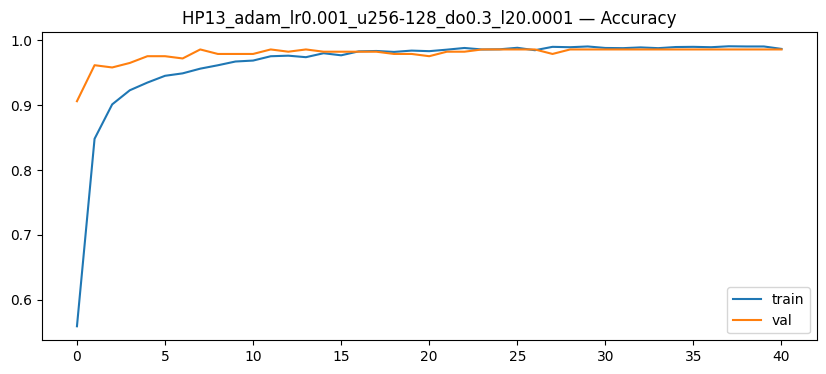

HP13_adam_lr0.001_u256-128_do0.3_l20.0001 — Test Acc=0.9861, Macro-F1=0.9860
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.973     1.000     0.986        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      0.973     1.000     0.986        36
           8      0.971     0.943     0.957        35
           9      1.000     0.972     0.986        36

    accuracy                          0.986       360
   macro avg      0.986     0.986     0.986       360
weighted avg      0.986     0.986     0.986       360



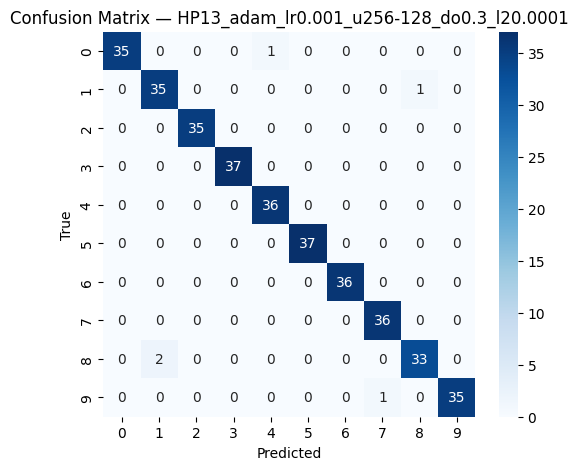

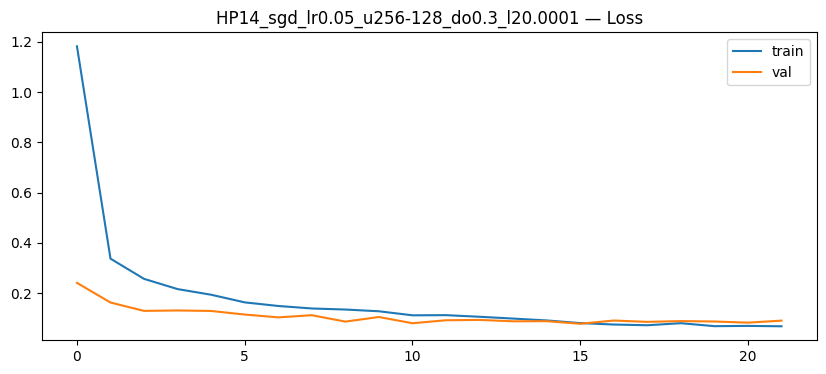

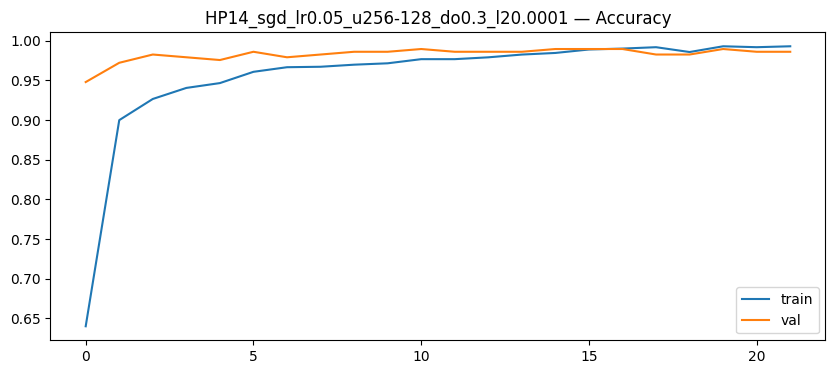

HP14_sgd_lr0.05_u256-128_do0.3_l20.0001 — Test Acc=0.9889, Macro-F1=0.9888
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        36
           1      0.946     0.972     0.959        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      1.000     1.000     1.000        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      1.000     1.000     1.000        36
           8      0.943     0.943     0.943        35
           9      1.000     0.972     0.986        36

    accuracy                          0.989       360
   macro avg      0.989     0.989     0.989       360
weighted avg      0.989     0.989     0.989       360



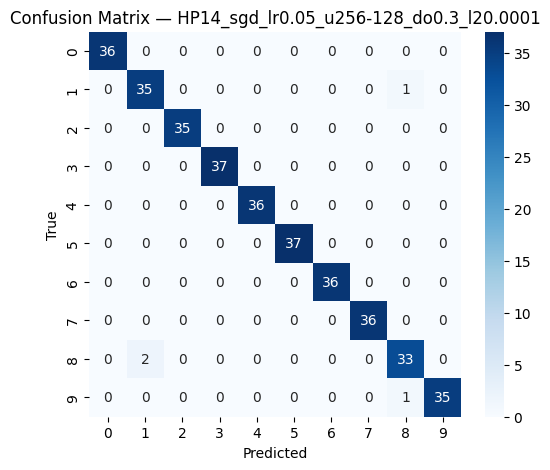

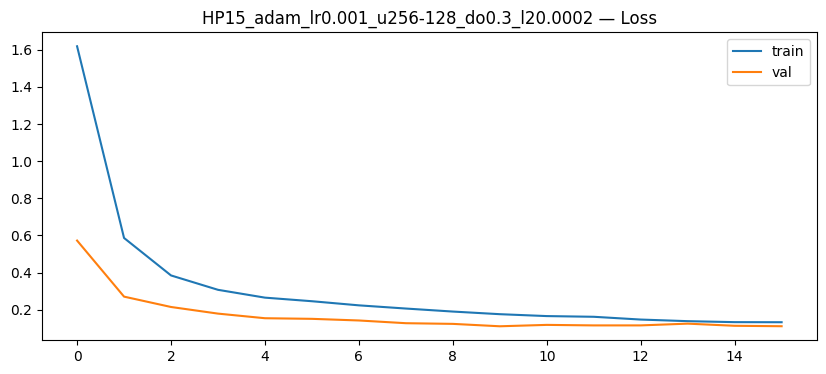

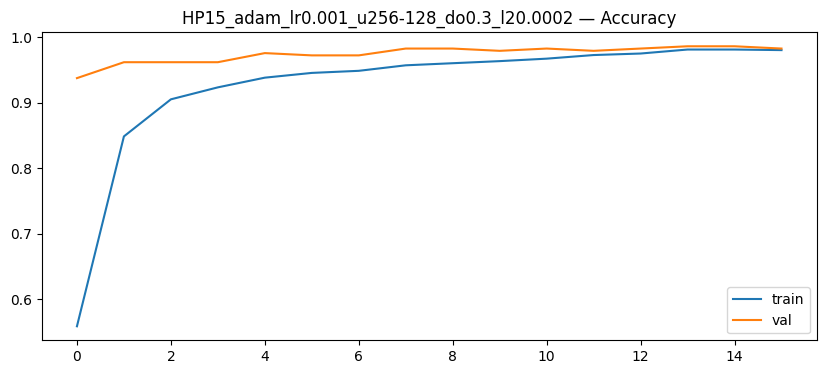

HP15_adam_lr0.001_u256-128_do0.3_l20.0002 — Test Acc=0.9778, Macro-F1=0.9777
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.919     0.944     0.932        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.973     1.000     0.986        36
           5      0.974     1.000     0.987        37
           6      1.000     1.000     1.000        36
           7      1.000     1.000     1.000        36
           8      0.914     0.914     0.914        35
           9      1.000     0.972     0.986        36

    accuracy                          0.978       360
   macro avg      0.978     0.978     0.978       360
weighted avg      0.978     0.978     0.978       360



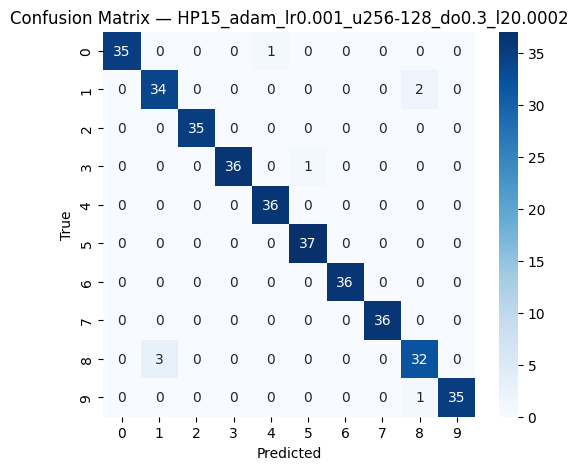

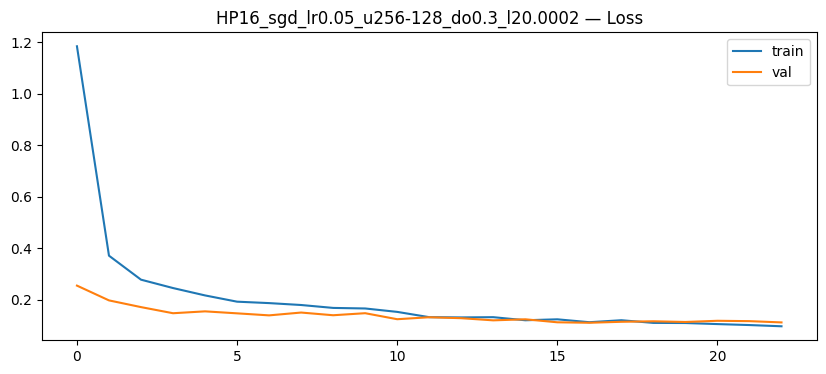

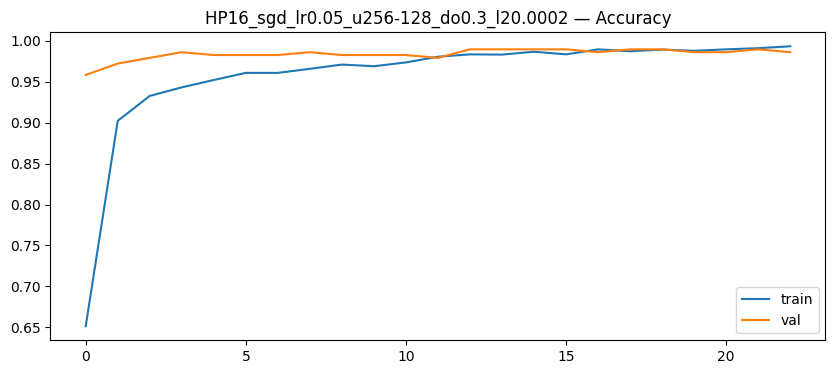

HP16_sgd_lr0.05_u256-128_do0.3_l20.0002 — Test Acc=0.9833, Macro-F1=0.9832
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.944     0.944     0.944        36
           2      1.000     1.000     1.000        35
           3      1.000     1.000     1.000        37
           4      0.973     1.000     0.986        36
           5      1.000     1.000     1.000        37
           6      1.000     1.000     1.000        36
           7      0.973     1.000     0.986        36
           8      0.971     0.943     0.957        35
           9      0.972     0.972     0.972        36

    accuracy                          0.983       360
   macro avg      0.983     0.983     0.983       360
weighted avg      0.983     0.983     0.983       360



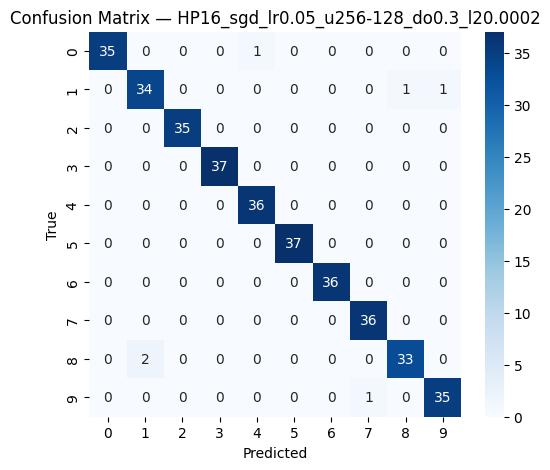

In [30]:
# =========================
# 5) Hyperparameter mini-grid
# =========================
print("\n=== Hyperparameter sweep ===")
results = []

units_grid   = [(128, 64), (256, 128)]
dropout_grid = [0.20, 0.30]
l2_grid      = [1e-4, 2e-4]
opt_grid     = ["adam", "sgd"]
lr_grid      = [1e-3, 5e-2]  # Adam typically ~1e-3; SGD can use larger lr (e.g., 5e-2)

# Filter combinations to avoid obviously mismatched lrs
filtered = []
for u, d, l2r, opt, lr in product(units_grid, dropout_grid, l2_grid, opt_grid, lr_grid):
    if opt == "adam" and lr > 0.01:
        continue
    if opt == "sgd" and lr < 0.01:
        continue
    filtered.append((u, d, l2r, opt, lr))

for i, (u, d, l2r, opt, lr) in enumerate(filtered, 1):
    name = f"HP{i}_{opt}_lr{lr}_u{u[0]}-{u[1]}_do{d}_l2{l2r}"
    res = run_experiment(name, u, d, l2r, opt, lr)
    results.append(res)



=== Final leaderboard (top 5) ===
                                       Model       Units  Dropout      L2  \
13   HP14_sgd_lr0.05_u256-128_do0.3_l20.0001  (256, 128)      0.3  0.0001   
9    HP10_sgd_lr0.05_u256-128_do0.2_l20.0001  (256, 128)      0.2  0.0001   
3      HP4_sgd_lr0.05_u128-64_do0.2_l20.0002   (128, 64)      0.2  0.0002   
8   HP9_adam_lr0.001_u256-128_do0.2_l20.0001  (256, 128)      0.2  0.0001   
0    HP1_adam_lr0.001_u128-64_do0.2_l20.0001   (128, 64)      0.2  0.0001   

     Opt     LR  Accuracy   MacroF1  
13   sgd  0.050  0.988889  0.988768  
9    sgd  0.050  0.986111  0.986105  
3    sgd  0.050  0.986111  0.986099  
8   adam  0.001  0.986111  0.986059  
0   adam  0.001  0.986111  0.985986  
Saved metrics to figs3/nn_metrics_summary.csv

Best model: HP14_sgd_lr0.05_u256-128_do0.3_l20.0001 | Acc=0.9889 | MacroF1=0.9888

=== Done Part 3 ===

=== (Optional) PyTorch MLP — comparison run ===


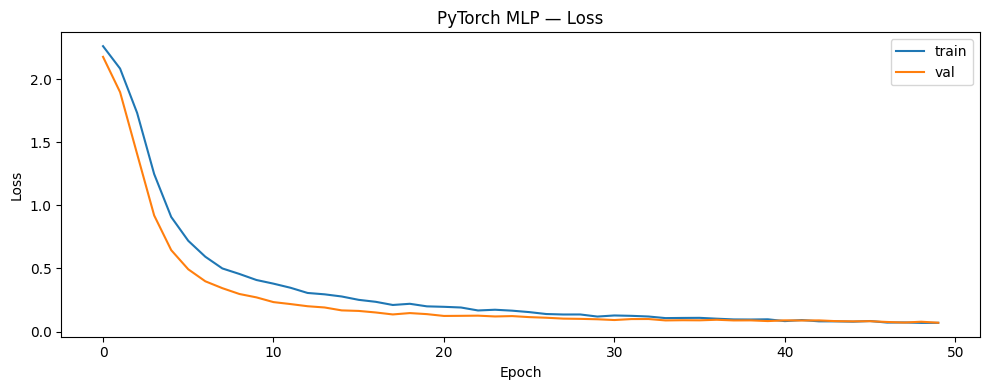

PyTorch MLP — Test Accuracy: 0.9778 | Macro-F1: 0.9777
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        36
           1      0.943     0.917     0.930        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      0.973     1.000     0.986        36
           5      0.974     1.000     0.987        37
           6      1.000     0.972     0.986        36
           7      1.000     1.000     1.000        36
           8      0.892     0.943     0.917        35
           9      1.000     1.000     1.000        36

    accuracy                          0.978       360
   macro avg      0.978     0.978     0.978       360
weighted avg      0.978     0.978     0.978       360



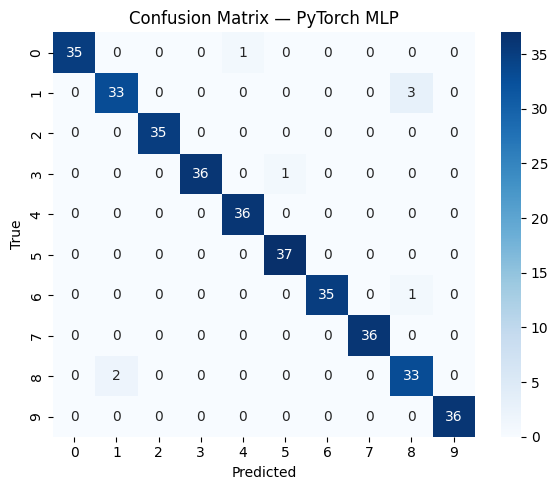

Saved PyTorch model to models3/torch_mlp_digits.pt
Updated leaderboard saved to: figs3/nn_metrics_summary.csv


In [31]:
# =========================
# 6) Summary leaderboard
# =========================
df = pd.DataFrame(results).sort_values(["MacroF1", "Accuracy"], ascending=False)
print("\n=== Final leaderboard (top 5) ===")
print(df.head(5))
df.to_csv(os.path.join(FIG_DIR, "nn_metrics_summary.csv"), index=False)
print("Saved metrics to", os.path.join(FIG_DIR, "nn_metrics_summary.csv"))

best = df.iloc[0]
print(f"\nBest model: {best['Model']} | Acc={best['Accuracy']:.4f} | MacroF1={best['MacroF1']:.4f}")

print("\n=== Done Part 3 ===")

# ============================================================
# OPTIONAL — PyTorch MLP (append-only, runs after Keras results)
# ============================================================
print("\n=== (Optional) PyTorch MLP — comparison run ===")

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    HAS_TORCH = True
except Exception as e:
    HAS_TORCH = False
    print("PyTorch not available, skipping. Error:", e)

if HAS_TORCH:
    # Reuse numpy splits prepared earlier
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tensors & loaders
    Xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.long)
    Xv  = torch.tensor(X_val, dtype=torch.float32)
    yv  = torch.tensor(y_val, dtype=torch.long)
    Xte = torch.tensor(X_test, dtype=torch.float32)
    yte = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(Xtr, ytr)
    val_ds   = TensorDataset(Xv, yv)
    test_ds  = TensorDataset(Xte, yte)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

    # Model (roughly aligned with Keras MLP: 128→64, ReLU, Dropout)
    class TorchMLP(nn.Module):
        def __init__(self, in_dim=64, hidden=(128, 64), p_drop=0.25):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden[0]), nn.ReLU(), nn.Dropout(p_drop),
                nn.Linear(hidden[0], hidden[1]), nn.ReLU(), nn.Dropout(p_drop),
                nn.Linear(hidden[1], 10)
            )
        def forward(self, x): return self.net(x)

    model_t = TorchMLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_t.parameters(), lr=1e-3)

    # Early stopping
    best_val = float("inf")
    patience, wait = 6, 0
    train_losses, val_losses = [], []

    for epoch in range(50):
        # Train
        model_t.train()
        tr_sum, tr_count = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model_t(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            tr_sum += loss.item() * xb.size(0); tr_count += xb.size(0)
        tr_loss = tr_sum / max(1, tr_count)
        train_losses.append(tr_loss)

        # Validate
        model_t.eval()
        v_sum, v_count = 0.0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model_t(xb)
                loss = criterion(logits, yb)
                v_sum += loss.item() * xb.size(0); v_count += xb.size(0)
        v_loss = v_sum / max(1, v_count)
        val_losses.append(v_loss)

        # EarlyStopping check
        if v_loss + 1e-6 < best_val:
            best_val = v_loss; wait = 0
            best_state = {k: v.cpu().clone() for k, v in model_t.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                break

    # Restore best weights
    model_t.load_state_dict(best_state)

    # Plot loss curves
    plt.figure(figsize=(10,4))
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.title("PyTorch MLP — Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
    savefig("Torch_MLP_loss.png"); plt.show()

    # Test evaluation
    model_t.eval()
    preds, gts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model_t(xb.to(device))
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            gts.extend(yb.numpy())
    preds = np.array(preds); gts = np.array(gts)

    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    acc_t = accuracy_score(gts, preds)
    f1_t  = f1_score(gts, preds, average="macro")
    print(f"PyTorch MLP — Test Accuracy: {acc_t:.4f} | Macro-F1: {f1_t:.4f}")
    print(classification_report(gts, preds, digits=3))

    # Confusion matrix
    cm_t = confusion_matrix(gts, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_t, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.title("Confusion Matrix — PyTorch MLP")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); savefig("Torch_MLP_confusion.png"); plt.show()

    # Save model
    torch.save(model_t.state_dict(), os.path.join(MODEL_DIR, "torch_mlp_digits.pt"))
    print("Saved PyTorch model to models3/torch_mlp_digits.pt")

    # Append to leaderboard CSV (if it exists), else create
    torch_row = pd.DataFrame([{
        "Model": "Torch_MLP",
        "Units": "(128, 64)",
        "Dropout": 0.25,
        "L2": 0.0,
        "Opt": "adam",
        "LR": 1e-3,
        "Accuracy": acc_t,
        "MacroF1": f1_t
    }])

    csv_path = os.path.join(FIG_DIR, "nn_metrics_summary.csv")
    if os.path.exists(csv_path):
        df_lb = pd.read_csv(csv_path)
        df_lb = pd.concat([df_lb, torch_row], ignore_index=True)
    else:
        df_lb = torch_row
    df_lb = df_lb.sort_values(["MacroF1", "Accuracy"], ascending=False)
    df_lb.to_csv(csv_path, index=False)
    print(f"Updated leaderboard saved to: {csv_path}")

else:
    print("PyTorch block skipped.")


Conclusion
----------

This lab demonstrated how a common data science workflow applies across diverse problem domains.  

In Part 1 (NLP), we saw that careful preprocessing (lowercasing, stopword removal, lemmatization, n-gram analysis) strongly influenced model performance and revealed domain-specific language patterns useful for routing support tickets.  

In Part 2 (Time Series), stationarity checks (ADF/KPSS) and decomposition highlighted underlying trends and volatility in the S&P 500. Comparing ARIMA, SARIMA, and baseline forecasts showed that rigorous model selection (via AIC/BIC and error metrics) leads to more reliable financial predictions that support budgeting and investment decisions.  

In Part 3 (Neural Networks), we experimented with multilayer perceptrons, regularization (Dropout, L2), and hyperparameter tuning. We compared implementations in both Keras and PyTorch, finding that similar architectures achieve comparable accuracy and F1-scores. Confusion matrices provided insights into which digits are most frequently misclassified, suggesting possible directions for further improvement.  

Overall, the lab emphasized a consistent problem-solving mindset: prepare data carefully, select and tune appropriate models, and evaluate results with meaningful metrics. These practices build confidence in applying data science techniques to real-world challenges across text, temporal, and image data.
